 @2026-2-2

+ 调节Fiete,2009的参数，改变bump的数量
+ 加入海马模块到grid中
+ phase detection
+ 多模式学习
+ 吸引子测试

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap
from matplotlib.animation import FuncAnimation
from scipy.stats import poisson
from datetime import datetime
from matplotlib import cm


## Parameters
+ Grid cells (Network generation)
+ Place cells
    + initialize 

### Grid

In [ ]:
N = 32   # grid cell number
# Network parameters
m = 5  # CV = 1/sqrt(m)
tau_s = 30/1000    # synaptic time constant (s)
# 偏好位置分布在0-1之间
x_prefs = np.arange(1, N+1).reshape(-1, 1) / N  # Inherited location preferences
# FeedForward input
e_mu = 1.5     # velocity gain
beta_0 = 70        # uniform input
g_gp = 10.0  # gain for place -> grid projections
# Graphing parameters
bins = np.linspace(0 + 0.01, 1 - 0.01, 50)

alpha = 1000       # weight imbalance parameter
alpha_bar = 1.001    # Center Surround weight params
gamma = 1.05/100   # Center Surround weight params
beta_w = 0.8/100     # Center Surround weight params (renamed to avoid conflict with beta_vel)
sigma1 = 1
sigma2 = 1
# x_range = 32    # 直接控制权重函数的x范围
# Relative indices for weight function
z = np.arange(-N/2, N/2, 1) # [-32,31)  # x从-N/2 - N/2
# z = np.linspace(-x_range, x_range, N)  # 这种方法不好控制中点为0
# Weight setup
crossSection = alpha * (alpha_bar*np.exp(-gamma * z**2/sigma1**2) - np.exp(-beta_w * z**2/sigma2**2))
crossSection_shift = np.roll(crossSection, int(N/2))
envelope = np.ones((N, 1)) # periodic topology

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
ax[0].plot(crossSection)
ax[0].set_title('before shift')
# Circular shift
# MATLAB: circshift(crossSection, [0 N/2 - 1])
# Shift right by N/2-1 positions (axis=0 for rows, axis=1 for columns)
ax[1].plot(crossSection_shift)
ax[1].set_title('after shift')
plt.show()

In [ ]:
# Initialize weight matrices
# MATLAB: zeros(N, N)
W_RR = np.zeros((N, N))
W_LL = np.zeros((N, N))
W_RL = np.zeros((N, N))
W_LR = np.zeros((N, N))
 # Construct weight matrices
for i in range(N):
    # MATLAB uses 1-based indexing, Python uses 0-based
    # In MATLAB: circshift(crossSection, [0 i - 1])
    # In Python: np.roll(crossSection, i - 1)
    W_RR[i, :] = np.roll(crossSection_shift, i - 1)  # Right neurons to Right neurons
    W_LL[i, :] = np.roll(crossSection_shift, i + 1)  # Left neurons to Left neurons
    W_RL[i, :] = np.roll(crossSection_shift, i + 1)  # Left neurons to Right neurons
    W_LR[i, :] = np.roll(crossSection_shift, i - 1)  # Right neurons to Left neurons

### HPC
设置海马模块的初始参数

In [ ]:
# Hippocampal (place cell) module parameters
Nh = 3200  # number of place cells
tau_h = 300 / 1000  # hippocampal time constant (s)
theta = 0.2  # activation threshold
hebb_lr = 1e-4  # Hebbian learning rate for place->grid synapses
epsilon = 1e-9
relu = lambda x: np.maximum(x, 0.0)
gain_pg = 1.0  # gain for grid -> place projections
Iext2 = 0.0  # external input to place cells
# Synaptic weights
W_pg = np.random.normal(0.0, 1.0, size=(Nh, 2 * N))  # grid -> place
# Create sparse connectivity mask for grid -> place projections
r_pg = 0.001  # sparsity ratio: retain 10% of connections
mask_pg = np.random.rand(Nh, 2 * N) < r_pg
W_pg = W_pg * mask_pg

# 初始从p->g的投射为0
Wgp_L = np.zeros((N, Nh))  # place -> left grid
Wgp_R = np.zeros((N, Nh))  # place -> right grid
p_prev = np.zeros((Nh, 1))  # initial place-cell activity


In [ ]:
# plt.imshow(W_pg)
# plt.colorbar()
# plt.xlabel('Grid Cells')
# plt.ylabel('Place Cells')   
# plt.title('Initial Grid to Place Cell Weights r={}'.format(r_pg)) 
# plt.show()

## One-Pattern Learning

### 1. Initializing: Grid only Simulation

生成位置轨迹

In [ ]:
# Temporal parameters
T = 10            # length of integration time blocks (s)
dt = 1/2000        # step size of numerical integration (s)

# Trajectory Data (Sinusoidal)
# MATLAB: dt:dt:T creates a range from dt to T with step dt
time_steps = np.arange(dt, T + dt, dt)
x = (np.sin(time_steps * 2 * np.pi / 10) + 1) / 2  # generate sine wave

# x = np.hstack([1/1000*np.arange(1000), np.zeros(len(time_steps)-1000)])  # flat trajectory
# Calculate velocity
v = np.zeros_like(x)
v[1:] = (x[1:] - x[:-1]) / dt  # more efficient than loop

# %matplotlib inline
# plt.figure()
# plt.plot(x)
# plt.show()

在加入海马模块前，先跑grid的部分，生成grid的初始状态

In [ ]:
# Fiete,2009
n_steps = int(T/dt)

# record population spikes
r_all = np.zeros((2*N, n_steps))

# calculate spike counts in each time step
s_prev = np.zeros((2*N, 1))      # Population activity (256,1)
spk = np.zeros((2*N, len(time_steps)))  # Total spiking
spk_count = np.zeros((2*N, 1))   # Current spiking
# v = np.zeros_like(x)
for t in range(1, n_steps):
    
    # two population of neurons
    # left population
    v_L = (1-e_mu * v[t])
    g_LL = W_LL @ s_prev[:N]
    g_LR = W_LR @ s_prev[N:]
    G_L = v_L * ((g_LL + g_LR) + envelope * beta_0)
    # RIGHT population
    v_R = (1 + e_mu * v[t])
    g_RR = W_RR @ s_prev[N:]  # R->R
    g_RL = W_RL @ s_prev[:N]  # L->R
    
    G_R = v_R * ((g_RR + g_RL) + envelope * beta_0)
    
    G = np.vstack([G_L, G_R])
        
    # Linear transfer function (ReLU) + Poisson Spike
    F = G * (G >= 0)  # ReLU activation

    # F_expanded = np.tile(F, (1, m)) * dt
    # spk_sub = poisson.rvs(F_expanded)  # Poisson random numbers
    # spk_count += np.sum(spk_sub, axis=1, keepdims=True)   # 在m个时间步长中累计发放数量
    # # Determine actual spikes for this time step
    # spk[:, t] = np.floor(spk_count.flatten() / m) # 
    # spk_count = spk_count % m  # Keep remainder 跨时间步骤累计参与的spike量
    spk[:, t:t+1] = F * dt  # Ensure expected spike count matches firing rate
    # Update population activity
    s_new = s_prev + spk[:, t:t+1] - s_prev * dt / tau_s
    s_prev = s_new
    r_all[:,t] = s_new.flatten()

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10,6))
# Initialize lines
line_left, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'r-', alpha=0.7, label='Left Population')
line_right, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'b-', alpha=0.7, label='Right Population')
line_combined, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'g-', linewidth=2, label='Combined')
# Add position indicator
pos_line = ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Current Position')
ax.set_xlim(0, 1)
ax.set_ylim(0, np.max(r_all) * 2.05)
ax.set_xlabel('Position Preference')
ax.set_ylabel('Neural Activity')
ax.set_title('1D grid Fiete 2009')
ax.legend()
ax.grid(True, alpha=0.3)
def update(frame):
    t_idx = frame
    
    # Update activity lines
    left_activity = r_all[:N, t_idx]
    right_activity = r_all[N:, t_idx]
    combined_activity = left_activity + right_activity
    
    line_left.set_ydata(left_activity)
    line_right.set_ydata(right_activity)
    line_combined.set_ydata(combined_activity)
    
    # Update position line
    current_pos = x[t_idx]
    pos_line.set_xdata([current_pos, current_pos])
    

    return line_left, line_right, line_combined, pos_line

# Create animation
frame_step = 20
ani = FuncAnimation(fig, update, frames=range(0, min(n_steps, 2000), frame_step),  # Limit to 1000 frames for performance
                    interval=50, blit=True, repeat=True)
plt.show()
plt.tight_layout()


In [ ]:
ani.event_source.stop()
%matplotlib inline

In [ ]:
plt.figure()
gL = r_all[:N,-1]
gR = r_all[N:2*N,-1]
g = np.mean(np.vstack([gL, gR]), axis=0)
plt.title('Initial grid pattern')
plt.plot(g)
plt.xlabel('Neuron Index')
plt.ylabel('Firing Rate')
plt.show()

In [ ]:
roll_g = np.roll(g, int(N/2))
plt.figure()
plt.plot(roll_g)
plt.title('Final grid pattern after learning')

### 2.  Training: Loop Simulation

1. 实时学习： 从grid初始状态出发，进行动力学迭代

In [ ]:
# Fiete,2009 with hippocampal feedback
T2 = 3
n_steps = int(T2/dt)
# g_gp = 0.01
v = np.zeros(int(T2/dt))   # 速度输入为0
# record population spikes
r_all = np.zeros((2*N, n_steps))
r_place = np.zeros((Nh, n_steps))
g = roll_g.copy()
s_prev = np.hstack([g,g]).T.reshape(-1,1)     # initialize with previous g
# calculate spike counts in each time step
# s_prev = np.zeros((2*N, 1))      # Population activity (2N,1)


In [ ]:
# 初始从p->g的投射为0
Wgp_L = np.zeros((N, Nh))  # place -> left grid
Wgp_R = np.zeros((N, Nh))  # place -> right grid
p_prev = np.zeros((Nh, 1))  # initial place-cell activity

spk = np.zeros((2*N, n_steps))  # Total spiking
spk_count = np.zeros((2*N, 1))   # Current spiking

# v = np.zeros_like(x)
for t in range(1, n_steps):
    
    # Hippocampal (place-cell) dynamics
    hippo_drive = gain_pg * W_pg @ s_prev + Iext2    # grid -> place input
    phi_term = relu(hippo_drive - theta).reshape(-1,1)
    p_new = p_prev + dt / tau_h * (-p_prev + phi_term)
    r_place[:, t:t+1] = p_new
    # print(r_place.max())
    # two population of neurons
    # left population
    v_L = (1-e_mu * v[t])
    g_LL = W_LL @ s_prev[:N]
    g_LR = W_LR @ s_prev[N:]
    G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_new
    # RIGHT population
    v_R = (1 + e_mu * v[t])
    g_RR = W_RR @ s_prev[N:]  # R->R
    g_RL = W_RL @ s_prev[:N]  # L->R
    G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_new

    G = np.vstack([G_L, G_R])
        
    # Linear transfer function (ReLU) + Poisson Spike
    F = G * (G >= 0)  # ReLU activation
    # 修改为确定性形式
    # spk_count = spk_count % m  # Keep remainder 跨时间步骤累计参与的spike量
    spk[:,t:t+1] = F * dt  # 确定性形式
    # Update population activity
    s_new = s_prev + spk[:, t:t+1] - s_prev * dt / tau_s
    r_all[:,t] = s_new.flatten()

    # Hebbian update for place -> grid synapses
    hebb_L = np.outer(s_prev[:N].flatten(), p_new.flatten())
    hebb_R = np.outer(s_prev[N:].flatten(), p_new.flatten())
    # break
    Wgp_L += hebb_lr * hebb_L
    Wgp_R += hebb_lr * hebb_R
    norms_L = np.linalg.norm(Wgp_L, axis=0, keepdims=True)   # axis = 1 对于每一行单独计算，即网格细胞输入归一化 
    norms_R = np.linalg.norm(Wgp_R, axis=0, keepdims=True)    # axis = 0 对于每一列单独计算, 位置细胞归一化.每个位置细胞的输出相同
    norms_L[norms_L == 0] = 1.0    # 避免除0问题
    norms_R[norms_R == 0] = 1.0 
    Wgp_L = Wgp_L / norms_L
    # print(np.sum(Wgp_L))
    Wgp_R = Wgp_R / norms_R
    # print(np.sum(Wgp_L))
    s_prev = s_new
    p_prev = p_new
   

###  单一pattern训练： 可视化

可视化学习后的Grid和HPC pattern

In [ ]:
%matplotlib inline
grid_pattern = np.mean(r_all[:2*N,-1].reshape(2,N), axis=0)
plt.figure()
plt.plot(grid_pattern)
plt.show()

In [ ]:
fig,ax_place = plt.subplots(1,1, figsize = (10,1))
initial_place = r_place[:, -1]
initial_vmax = max(initial_place.max(), 1e-9)
pattern_im = ax_place.imshow(
    initial_place[None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=initial_vmax,
)
ax_place.set_yticks([])
ax_place.set_xlabel('Place cell index')
ax_place.set_title('Hippocampal activity (last timestamp)')
ax_place.set_xlim(0, Nh)

##### 可视化突触权重和网络迭代的过程

可视化Wgp

In [ ]:
# 可视化W_gp
fig, (ax_L, ax_R) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Wgp_L
im_L = ax_L.imshow(Wgp_L, aspect='auto', cmap='viridis')
ax_L.set_xlabel('Place cell index')
ax_L.set_ylabel('Grid cell index (Left)')
ax_L.set_title(f'Wgp_L (sum={Wgp_L.sum():.2f})')
cbar_L = plt.colorbar(im_L, ax=ax_L, orientation='vertical', pad=0.02, fraction=0.046)

# Plot Wgp_R
im_R = ax_R.imshow(Wgp_R, aspect='auto', cmap='viridis')
ax_R.set_xlabel('Place cell index')
ax_R.set_ylabel('Grid cell index (Right)')
ax_R.set_title(f'Wgp_R (sum={Wgp_R.sum():.2f})')
cbar_R = plt.colorbar(im_R, ax=ax_R, orientation='vertical', pad=0.02, fraction=0.046)

# Set global colorbar limits
vmax_global = max(Wgp_L.max(), Wgp_R.max())
vmin_global = min(Wgp_L.min(), Wgp_R.min())
im_L.set_clim(vmin_global, vmax_global)
im_R.set_clim(vmin_global, vmax_global)

plt.tight_layout()
plt.show()


迭代动画

In [ ]:
%matplotlib widget
fig, (ax, ax_place) = plt.subplots(
    2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [4, 0.8], 'hspace': 0.4}
 )
# Initialize grid-cell activity lines
line_left, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'r-', alpha=0.7, label='Left Population')
line_right, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'b-', alpha=0.7, label='Right Population')
line_combined, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'g-', linewidth=2, label='Combined')
# Add position indicator
# pos_line = ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Current Position')

ax.set_xlim(0, 1)
ax.set_ylim(0, np.max(r_all) * 2.1)
ax.set_autoscalex_on(False)
ax.set_autoscaley_on(False)
ax.set_xlabel('Position Preference')
ax.set_ylabel('Neural Activity')
# ax.set_title('1D grid Fiete 2009 x = {}')
ax.legend()
ax.grid(True, alpha=0.3)

# Hippocampal activity heatmap (1D vector displayed as a thin strip)
initial_place = r_place[:, 0]
initial_vmax = max(initial_place.max(), 1e-9)
pattern_im = ax_place.imshow(
    initial_place[None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=initial_vmax,
)
ax_place.set_yticks([])
ax_place.set_xlabel('Place cell index')
ax_place.set_title('Hippocampal activity (current timestep)')
ax_place.set_xlim(0, Nh)
# 创建垂直colorbar并设置位置
cbar = fig.colorbar(pattern_im, ax=ax_place, orientation='vertical', 
                    pad=0.05, fraction=0.05, shrink=0.8)
cbar.set_label('FR(norm)', rotation=270, labelpad=15)
# 或者使用set_position调整（单位为图形坐标）
# cbar.ax.set_position([0.85, 0.15, 0.02, 0.7])  # [左, 下, 宽, 高]
def update(frame):
    t_idx = frame
        

    # Update activity lines
    left_activity = r_all[:N, t_idx]
    right_activity = r_all[N:, t_idx]
    combined_activity = left_activity + right_activity

    line_left.set_ydata(left_activity)
    line_right.set_ydata(right_activity)
    line_combined.set_ydata(combined_activity)
    # Update title
    ax.set_title(f' t = {dt * t_idx:.4f}s x = {round(x[t_idx], 2)}')
    # Update position line
    # current_pos = x[t_idx]
    # pos_line.set_xdata([current_pos, current_pos])
    
    # Update hippocampal heatmap
    place_activity = r_place[:, t_idx]
    vmax = max(place_activity.max(), 1e-9)
    pattern_im.set_data(place_activity[None, :])
    pattern_im.set_clim(0, vmax)
    cbar.update_normal(pattern_im)

    return line_left, line_right, line_combined, pattern_im

# Create animation
frame_step = 20
ani = FuncAnimation(
    fig,
    update,
    frames=range(0, min(n_steps, 20000), frame_step),  # Limit to 1000 frames for performance
    interval=50,
    blit=True,
    repeat=True,
 )
plt.show()
plt.tight_layout()


In [ ]:
ani.event_source.stop()
%matplotlib inline

In [ ]:
print("Saving animation...")
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, f'p3200-grid32_1M1D_{N}'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")

### 3. 吸引子验证
+ 提取grid_org（s_prev）左右环平均, 为
+ 从grid pattern投射到p，得到p_org
+ 加入高斯噪声，从p_org得到p_noise
+ 从p_noise开始更新，观察网络输出g_output是否会收敛回到grid_org

In [ ]:
from numpy import dot
from numpy.linalg import norm
def euclidean_similarity(v1, v2):
    dist = np.linalg.norm(v1 - v2)
    # 将距离转换为相似度（0-1范围）
    similarity = 1 / (1 + dist)
    return similarity
def cosine_similarity(v1, v2):
    """
    计算两个向量的余弦相似度
    范围：[-1, 1]，1表示完全相同，0表示正交，-1表示完全相反
    """
    cos_sim = dot(v1, v2) / (norm(v1) * norm(v2))
    return cos_sim

In [ ]:
grid_org = np.mean(r_all[:2*N,-1].reshape(2,N), axis=0)
p_org = r_place[:, -1]

In [ ]:
def g_p_denoise(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, noise_std = 0.2, sim_measure = 'Cosine'):
    '''验证学习后的网络的去噪能力
    返回噪声后的初始位置细胞状态p_noise，最终位置细胞状态p_test，(最后)位置细胞相似度sim
    ----------  
   '''
    # place cell initial state with noise_std
    p_noise = p_org + np.random.normal(0, noise_std, p_org.shape)
    p_noise = np.maximum(p_noise, 0)  # ensure non-negative
    
    # r_test = np.zeros((len(grid_org)*2, 1))

    # grid的初始状态
    # s_test = np.hstack([grid_org, grid_org]).T.reshape(-1, 1)  # (128, 1)
    s_test = np.zeros((len(grid_org)*2,1))
    n_steps_test = int(T_max/dt)
    v_test = np.zeros(n_steps_test)  # zero velocity for attractor test


    # s_test为前一时刻的grid活动
    t = 1
    sim = 0.0
    p_test = p_noise.copy()
    while (sim < 0.99) & (t < n_steps_test - 1):
        # Grid cell dynamics (no learning, fixed weights)
        v_L = 1 - e_mu * v_test[t]
        v_R = 1 + e_mu * v_test[t]
        
        g_LL = W_LL @ s_test[:N]
        g_LR = W_LR @ s_test[N:]
        g_RR = W_RR @ s_test[N:]
        g_RL = W_RL @ s_test[:N]
    
        G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_test.reshape(-1,1)
        G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_test.reshape(-1,1)
        
        G = np.vstack([G_L, G_R])
        F = G * (G >= 0)
        
        s_new = s_test + F * dt - s_test * dt / tau_s
        # grid activity更新并储存
        # r_test[:, t] = s_new.flatten()
        s_test = s_new
        
        # Place cell dynamics
        hippo_drive = gain_pg * W_pg @ s_new + Iext2
        phi_term = relu(hippo_drive - theta).reshape(-1, 1)
        p_new = p_test + dt / tau_h * (-p_test + phi_term.flatten())
        # r_place_test[:, t:t+1] = p_new.reshape(-1, 1)
        p_test = p_new.flatten()
        if sim_measure == 'Eucliean':
            sim = euclidean_similarity(p_new, p_org)
        elif sim_measure == 'Cosine':
            sim = cosine_similarity(p_new, p_org)
        t += 1
    return p_noise, p_test, sim

In [ ]:
def g_p_denoise_process(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, noise_std = 0.2, sim_measure = 'Cosine'):
    '''验证学习后的网络的去噪能力
    在g_p_denoise()的基础上返回每一时刻的sim
    p_noise: 去噪声前
    p_test: 去噪声后
    sim_arr: 相似度数组 shape = (timestamps, 1)
    '''
    # place cell initial state with noise_std
    p_noise = p_org + np.random.normal(0, noise_std, p_org.shape)
    p_noise = np.maximum(p_noise, 0)  # ensure non-negative

    # grid的初始状态
    # s_test = np.hstack([grid_org, grid_org]).T.reshape(-1, 1)  # (128, 1)
    s_test = np.zeros((len(grid_org)*2,1))
    n_steps_test = int(T_max/dt)
    v_test = np.zeros(n_steps_test)  # zero velocity for attractor test


    # s_test为前一时刻的grid活动
    t = 1
    sim = 0.0
    sim_arr = np.zeros(int(T_max/dt))
    p_test = p_noise.copy()
    while (t < n_steps_test):
        # Grid cell dynamics (no learning, fixed weights)
        v_L = 1 - e_mu * v_test[t]
        v_R = 1 + e_mu * v_test[t]
        
        g_LL = W_LL @ s_test[:N]
        g_LR = W_LR @ s_test[N:]
        g_RR = W_RR @ s_test[N:]
        g_RL = W_RL @ s_test[:N]
    
        G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_test.reshape(-1,1)
        G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_test.reshape(-1,1)
        
        G = np.vstack([G_L, G_R])
        F = G * (G >= 0)
        
        s_new = s_test + F * dt - s_test * dt / tau_s
        # grid activity更新并储存
        # r_test[:, t] = s_new.flatten()
        s_test = s_new
        
        # Place cell dynamics
        hippo_drive = gain_pg * W_pg @ s_new + Iext2
        phi_term = relu(hippo_drive - theta).reshape(-1, 1)
        p_new = p_test + dt / tau_h * (-p_test + phi_term.flatten())
        # r_place_test[:, t:t+1] = p_new.reshape(-1, 1)
        p_test = p_new.flatten()
        if sim_measure == 'Eucliean':
            sim = euclidean_similarity(p_new, p_org)
        elif sim_measure == 'Cosine':
            sim = cosine_similarity(p_new, p_org)
        sim_arr[t] = sim
        t += 1
    return p_noise, p_test, sim_arr

In [ ]:
def attractor_test2(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, Nrun = 100,noise_stds = [2], sim_measure = 'Cosine'):
    Nn = len(noise_stds)
    n_steps_test = int(T_max / dt)
    p_sim_all = np.zeros((Nrun, Nn, n_steps_test))  # collect p similarity over time_steps
    for n in range(Nn):
        noise_std = noise_stds[n]
        for r in range(Nrun):
            p_noise, p_denoised, sim_array = g_p_denoise_process(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max, dt, noise_std, sim_measure)
            p_sim_all[r, n, :] = sim_array
    
    return p_sim_all

In [ ]:
ls_noise = [0,2,4,8,10,20,40]
T_max = 1.5
dt = 0.01
p_sim = attractor_test2(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = T_max, dt = dt,
                        Nrun = 100,noise_stds = ls_noise, sim_measure = 'Cosine')

# plot the results
plt.figure(figsize=(10, 6))
plt.grid(True, color = 'grey', ls = 'dashed', lw = 2, alpha=0.3)
for i, noise_std in enumerate(ls_noise):
    mean_sim = np.mean(p_sim[:, i, :], axis=0)
    std_sim = np.std(p_sim[:, i, :], axis=0)
    # plt.errorbar(np.arange(0,T_max, dt), mean_sim, yerr=std_sim, label=f'Noise STD={noise_std}')
    plt.fill_between(np.arange(0, T_max, dt), mean_sim - std_sim, mean_sim + std_sim, alpha=0.15)
    plt.plot(np.arange(0, T_max, dt), mean_sim, label=f'Noise STD={noise_std}', linewidth=2)
plt.ylim(0,1.1)

plt.xlabel('Time step')
plt.ylabel('Similarity')
plt.title('Attractor Test: Place Cell Similarity Over Time')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# test
n_std = 5
t_max = 2
p_noise, p_final, sim = g_p_denoise(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = t_max, 
                                    dt = 0.01, noise_std = n_std,
                                    sim_measure = 'Cosine')

# visualization of original and noisy place cell activity
fig, ax_place_noise = plt.subplots(3,1, figsize = (10,3))

noise_vmax = max(p_noise.max(), 1e-9)   
fig.suptitle(f'Denoising{T_max}s, noise_std={n_std}, final_sim={sim:.3}')
pattern_im_org = ax_place_noise[0].imshow(
    p_org[None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=noise_vmax,
)
pattern_im_noise = ax_place_noise[1].imshow(
    p_noise[None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=noise_vmax,
)
pattern_im_final = ax_place_noise[2].imshow(
    p_final[None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=noise_vmax,
)

ax_place_noise[0].set_yticks([])
# ax_place_noise[0].set_xlabel('Place cell index')
ax_place_noise[0].set_title('Original hippocampal activity (last timestamp)')
ax_place_noise[0].set_xlim(0, Nh)
ax_place_noise[1].set_yticks([])
# ax_place_noise[1].set_xlabel('Place cell index')   
ax_place_noise[1].set_title('Noisy hippocampal activity')
ax_place_noise[1].set_xlim(0, Nh)
ax_place_noise[2].set_yticks([])
ax_place_noise[2].set_xlabel('Place cell index')   
ax_place_noise[2].set_title('Final hippocampal activity')
ax_place_noise[2].set_xlim(0, Nh)
plt.tight_layout()
plt.show()


噪声从p加入，从p_org变成p_noise  
grid cell的初始状态：  
1. 初始活动为0，从只接收p的投射开始演化
2. 初始活动为g_org (即无噪声前的)

In [ ]:
%matplotlib widget
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 1, height_ratios=[3, 0.8, 0.8], hspace=0.4)
ax_grid = fig.add_subplot(gs[0])
ax_place_org = fig.add_subplot(gs[1])
ax_place_test = fig.add_subplot(gs[2])
s_org_mean =  s_org              # np.mean(s_org.reshape(2,-1), axis=0)
# Initialize grid cell plot
line_org, = ax_grid.plot(x_prefs.flatten(), s_org_mean.flatten(), 'gray', linestyle='--', linewidth=2, alpha=0.7, label='s_org')
line_current, = ax_grid.plot(x_prefs.flatten(), np.zeros(N), 'b-', linewidth=2, label='Current grid pattern')
ax_grid.set_xlim(0, 1)
ax_grid.set_ylim(0, np.max(s_org) * 1.2)
ax_grid.set_xlabel('Position Preference')
ax_grid.set_ylabel('Neural Activity')
ax_grid.set_title('Grid Cell Denoising')
ax_grid.legend()
ax_grid.grid(True, alpha=0.3)

# Initialize original place cell heatmap
vmax_place = max(p_org.max(), 1e-9)
im_org = ax_place_org.imshow(
    p_org[None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=vmax_place,
)
ax_place_org.set_yticks([])
ax_place_org.set_ylabel('Original')
ax_place_org.set_xlim(0, Nh)
cbar_org = plt.colorbar(im_org, ax=ax_place_org, orientation='vertical', pad=0.02, fraction=0.046)
cbar_org.set_label('FR', rotation=270, labelpad=15)

# Initialize current place cell heatmap
im_test = ax_place_test.imshow(
    p_test[:, 0][None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=vmax_place,
)
ax_place_test.set_yticks([])
ax_place_test.set_xlabel('Place Cell Index')
ax_place_test.set_ylabel('Current')
ax_place_test.set_xlim(0, Nh)
cbar_test = plt.colorbar(im_test, ax=ax_place_test, orientation='vertical', pad=0.02, fraction=0.046)
cbar_test.set_label('FR', rotation=270, labelpad=15)

def update(frame):
    t_idx = frame
    
    # Update grid cell pattern
    grid_current = np.mean(r_test[:, t_idx].reshape(2, N), axis=0)
    line_current.set_ydata(grid_current)
    ax_grid.set_title(f'Grid started from Zero activity (t = {dt * t_idx:.4f}s)')
    
    # Update current place cell activity
    place_current = p_test[:, t_idx]
    im_test.set_data(place_current[None, :])
    vmax_current = max(place_current.max(), 1e-9)
    im_test.set_clim(0, vmax_current)
    cbar_test.update_normal(im_test)
    
    return line_current, im_test

# ani = FuncAnimation(
#     fig,
#     update,
#     frames=range(n_steps_test),
#     interval=50,
#     blit=True,
#     repeat=True,
# )
# plt.show()
# Save animation with frame skipping for smoother playback
skip = 100  # display every 10th frame
ani = FuncAnimation(
    fig,
    update,
    frames=range(0, n_steps_test, skip),
    interval=50,
    blit=True,
    repeat=True,
)
plt.show()

In [ ]:
ani.event_source.stop()
%matplotlib inline


In [ ]:

print("Saving animation...")
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, f'grid_dnoise2_1M1D_{N}'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")

### Visualization

学习后：可视化W_gp

### Former Codes 

In [ ]:
# # Fiete,2009
# n_steps = int(T/dt)

# # record population spikes
# r_all = np.zeros((2*N, n_steps))

# # calculate spike counts in each time step
# s_prev = np.zeros((2*N, 1))      # Population activity (256,1)
# spk = np.zeros((2*N, len(time_steps)))  # Total spiking
# spk_count = np.zeros((2*N, 1))   # Current spiking
# # v = np.zeros_like(x)
# for t in range(1, n_steps):
    
#     # two population of neurons
#     # left population
#     v_L = (1-e_mu * v[t])
#     g_LL = W_LL @ s_prev[:N]
#     g_LR = W_LR @ s_prev[N:]
#     G_L = v_L * ((g_LL + g_LR) + envelope * beta_0)
#     # RIGHT population
#     v_R = (1 + e_mu * v[t])
#     g_RR = W_RR @ s_prev[N:]  # R->R
#     g_RL = W_RL @ s_prev[:N]  # L->R
    
#     G_R = v_R * ((g_RR + g_RL) + envelope * beta_0)
    
#     G = np.vstack([G_L, G_R])
        
#     # Linear transfer function (ReLU) + Poisson Spike
#     F = G * (G >= 0)  # ReLU activation
#     F_expanded = np.tile(F, (1, m)) * dt
#     spk_sub = poisson.rvs(F_expanded)  # Poisson random numbers
#     spk_count += np.sum(spk_sub, axis=1, keepdims=True)   # 在m个时间步长中累计发放数量
#     # Determine actual spikes for this time step
#     spk[:, t] = np.floor(spk_count.flatten() / m) # 
#     spk_count = spk_count % m  # Keep remainder 跨时间步骤累计参与的spike量
    
#     # Update population activity
#     s_new = s_prev + spk[:, t:t+1] - s_prev * dt / tau_s
#     s_prev = s_new
#     r_all[:,t] = s_new.flatten()

In [ ]:
# %matplotlib widget
# fig, ax = plt.subplots(figsize=(10,6))
# # Initialize lines
# line_left, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'r-', alpha=0.7, label='Left Population')
# line_right, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'b-', alpha=0.7, label='Right Population')
# line_combined, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'g-', linewidth=2, label='Combined')
# # Add position indicator
# pos_line = ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Current Position')

# ax.set_xlim(0, 1)
# ax.set_ylim(0, np.max(r_all) * 2.1)
# ax.set_autoscalex_on(False)
# ax.set_autoscaley_on(False)
# ax.set_xlabel('Position Preference')
# ax.set_ylabel('Neural Activity')
# # ax.set_title('1D grid Fiete 2009 x = {}')
# ax.legend()
# ax.grid(True, alpha=0.3)
# def update(frame):
#     t_idx = frame
    
#     # Update activity lines
#     left_activity = r_all[:N, t_idx]
#     right_activity = r_all[N:, t_idx]
#     combined_activity = left_activity + right_activity
    
#     line_left.set_ydata(left_activity)
#     line_right.set_ydata(right_activity)
#     line_combined.set_ydata(combined_activity)
#     # Update title
#     ax.set_title(f' t = {dt * t_idx:.4f}s x = {round(x[t_idx],2)}')
#     # Update position line
#     current_pos = x[t_idx]
#     pos_line.set_xdata([current_pos, current_pos])
    

#     return line_left, line_right, line_combined, pos_line

# # Create animation
# frame_step = 20
# ani = FuncAnimation(fig, update, frames=range(0, min(n_steps, 20000), frame_step),  # Limit to 1000 frames for performance
#                     interval=50, blit=True, repeat=True)
# plt.show()
# plt.tight_layout()



## Multi-Pattern Learning

### Simulate Grid on a Trajectory
收集和统计grid状态

#### Trajectory generation

In [ ]:
# Temporal parameters
T = 50            # length of integration time blocks (s)
dt = 1/2000        # step size of numerical integration (s)
tau_s = 30/1000    # synaptic time constant (s)

# Trajectory Data (Sinusoidal)
time_steps = np.arange(dt, T + dt, dt)
x = (np.sin(time_steps * 2 * np.pi / 10) + 1) / 2  # generate sine wave

# x = np.hstack([1/1000*np.arange(1000), np.zeros(len(time_steps)-1000)])  # flat trajectory
# Calculate velocity
v = np.zeros_like(x)
v[1:] = (x[1:] - x[:-1]) / dt  # more efficient than loop

%matplotlib inline
plt.figure()
plt.plot(x)
plt.xlabel( 'Time (s)')
plt.ylabel('Position')
plt.title('Trajectory over Time')
plt.show()

#### Grid simulation

In [ ]:
# Fiete,2009
n_steps = int(T/dt)

# record population spikes
r_all = np.zeros((2*N, n_steps))

# calculate spike counts in each time step
s_prev = np.zeros((2*N, 1))      # Population activity (256,1)
spk = np.zeros((2*N, len(time_steps)))  # Total spiking
spk_count = np.zeros((2*N, 1))   # Current spiking
# v = np.zeros_like(x)
for t in range(1, n_steps):
    
    # two population of neurons
    # left population
    v_L = (1-e_mu * v[t])
    g_LL = W_LL @ s_prev[:N]
    g_LR = W_LR @ s_prev[N:]
    G_L = v_L * ((g_LL + g_LR) + envelope * beta_0)
    # RIGHT population
    v_R = (1 + e_mu * v[t])
    g_RR = W_RR @ s_prev[N:]  # R->R
    g_RL = W_RL @ s_prev[:N]  # L->R
    
    G_R = v_R * ((g_RR + g_RL) + envelope * beta_0)
    
    G = np.vstack([G_L, G_R])
        
    # Linear transfer function (ReLU) + Poisson Spike
    F = G * (G >= 0)  # ReLU activation

    # F_expanded = np.tile(F, (1, m)) * dt
    # spk_sub = poisson.rvs(F_expanded)  # Poisson random numbers
    # spk_count += np.sum(spk_sub, axis=1, keepdims=True)   # 在m个时间步长中累计发放数量
    # # Determine actual spikes for this time step
    # spk[:, t] = np.floor(spk_count.flatten() / m) # 
    # 修改为确定性形式
    # spk_count = spk_count % m  # Keep remainder 跨时间步骤累计参与的spike量
    spk[:,t:t+1] = F * dt  # 确定性形式
    # Update population activity
    s_new = s_prev + spk[:, t:t+1] - s_prev * dt / tau_s
    s_prev = s_new
    r_all[:,t] = s_new.flatten()

#### Visualization
+ animation
+ phase heat plot

In [ ]:
cur_dir = os.getcwd()
folder = 'visualization'

time = datetime.now().strftime("%m%d_%H")
folder_path = os.path.join(cur_dir,folder, time)
os.makedirs(folder_path, exist_ok=True)

In [ ]:
%matplotlib inline
left_activity = r_all[:N, :]
right_activity = r_all[N:, :]
combined_activity = left_activity + right_activity
print(combined_activity.shape)
im = plt.imshow(np.roll(combined_activity, shift=10, axis=0), aspect='auto', extent=[0, n_steps, 0, 1])
plt.xlabel('Time (s)')
plt.ylabel('Neuron Position')   
plt.colorbar(im, label='Activity Level')
plt.title('Population Activity Over Time')
plt.plot(1-x, color = 'r', label = 'real position')
plt.show()

In [ ]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(10,6))
# Initialize lines
line_left, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'r-', alpha=0.7, label='Left Population')
line_right, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'b-', alpha=0.7, label='Right Population')
line_combined, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'g-', linewidth=2, label='Combined')
# Add position indicator
pos_line = ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Current Position')

ax.set_xlim(0, 1)
ax.set_ylim(0, np.max(r_all) * 2.1)
ax.set_autoscalex_on(False)
ax.set_autoscaley_on(False)
ax.set_xlabel('Position Preference')
ax.set_ylabel('Neural Activity')
# ax.set_title('1D grid Fiete 2009 x = {}')
ax.legend()
ax.grid(True, alpha=0.3)
def update(frame):
    t_idx = frame
    
    # Update activity lines
    left_activity = r_all[:N, t_idx]
    right_activity = r_all[N:, t_idx]
    combined_activity = left_activity + right_activity
    
    line_left.set_ydata(left_activity)
    line_right.set_ydata(right_activity)
    line_combined.set_ydata(combined_activity)
    # Update title
    ax.set_title(f' t = {dt * t_idx:.4f}s x = {round(x[t_idx],2)}')
    # Update position line
    current_pos = x[t_idx]
    pos_line.set_xdata([current_pos, current_pos])
    

    return line_left, line_right, line_combined, pos_line

# Create animation
frame_step = 20
ani = FuncAnimation(fig, update, frames=range(0, min(n_steps, 20000), frame_step),  # Limit to 1000 frames for performance
                    interval=50, blit=True, repeat=True)
plt.show()
plt.tight_layout()


In [ ]:
ani.event_source.stop()
%matplotlib inline

In [ ]:
print("Saving animation...")
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, f'Fiete2009_1D_{N}'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")

### Phase Readout

In [ ]:
left_activity = r_all[:N, :]
right_activity = r_all[N:, :]
combined_activity = left_activity + right_activity
print(combined_activity.shape)

#### Winner-Take-All 

In [ ]:
# Winner-Take-All (WTA) readout
# keep `top_n` most active neurons at each timestep
N_neurons, n_steps = combined_activity.shape
print(f"combined_activity shape: {combined_activity.shape}")

top_n = 1  # change this to keep more/fewer winners per timestep
wta_activity = np.zeros_like(combined_activity, dtype=int)

# indices of the top_n neurons for every timestep (columns)
top_idx = np.argpartition(combined_activity, -top_n, axis=0)[-top_n:, :]
col_idx = np.broadcast_to(np.arange(n_steps), top_idx.shape)
wta_activity[top_idx, col_idx] = 1
# print(f"WTA matrix shape: {wta_activity.shape}, dtype: {wta_activity.dtype}")

# fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# im0 = axes[0].imshow(combined_activity, aspect='auto', cmap='magma',
#                      extent=[0, n_steps, 0, 1])
# axes[0].set_ylabel('Neuron Preference')
# axes[0].set_title('Population Activity (raw)')
# plt.colorbar(im0, ax=axes[0], orientation='vertical', label='Activity')

# im1 = axes[1].imshow(wta_activity, aspect='auto', cmap=cm.binary,
#                      extent=[0, n_steps, 0, 1], vmin=0, vmax=1)
# axes[1].set_xlabel('Timestep Index')
# axes[1].set_ylabel('Neuron Preference')
# axes[1].set_title(f'WTA mask (top {top_n})')
# plt.colorbar(im1, ax=axes[1], orientation='vertical', label='Winner')

# plt.tight_layout()
# plt.show()

相位筛选

In [ ]:
# Count distinct activity patterns over time (based on WTA mask)
if 'wta_activity' not in locals():
    raise RuntimeError('Run the WTA cell first to create wta_activity.')

# 去掉头尾各10000个时间步，避免边缘效应
wta_activity_cut = wta_activity[:,10000:-10000]
# 沿神经元维度进行打包压缩，每个时间点的神经模式压缩为长度 n_packed
packed_patterns = np.packbits(wta_activity_cut.astype(np.uint8), axis=0)
# 找出唯一模式及其索引
unique_patterns, inverse_idx = np.unique(packed_patterns, axis=1, return_inverse=True)
# unique_patterns:(n_packed,34) 
# inverse_idx: (n_timepoints,)1D向量，每个元素是每个时间点对应模式索引
# print(unique_patterns.shape)
# 长度为模式数量，元素为模型频数
pattern_counts = np.bincount(inverse_idx)
total_unique = unique_patterns.shape[1]
print(f"Unique patterns: {total_unique}")
# sort patterns by frequency 对pattern根据频数排序
order = np.argsort(pattern_counts)[::-1]
pattern_counts = pattern_counts[order]
unique_patterns = unique_patterns[:, order]
# 这里出现的unique_patterns中很可能包含少数的噪声模式
low_idx = np.argwhere(pattern_counts<=5)  # 查看最少频数
low_idx.flatten()

In [ ]:
# 可视化unique_patterns
unpacked_patterns = [
    np.unpackbits(unique_patterns[:, i], count=wta_activity_cut.shape[0])
    for i in range(total_unique)
]
fig, axes = plt.subplots(1, 1, figsize=(4, 8), sharex=False)
uni_matrix = np.stack(unpacked_patterns)
uni_sorted = uni_matrix
order = np.lexsort((-uni_sorted).T[::-1])  # reverse columns because lexsort works right→left
sorted_rows = uni_sorted[order[::-1]]      # flip to get descending

sorted_low_idex = np.array([np.argwhere(order==i)[0][0] for i in low_idx]) # 找到原本出现数量少的pattern在排序后的索引位置
print(sorted_rows) 
axes.imshow(sorted_rows, aspect='auto', cmap=cm.binary,
                extent=[0, 1, 0, len(unpacked_patterns)])
# Highlight low-frequency patterns in red
for idx in sorted_low_idex.flatten():
    axes.axhline(y=idx, color='red', linewidth=2, alpha=0.7, label = 'Low frequency pattern (<=5)')
axes.set_ylabel('Pattern index')
axes.legend()
axes.set_xlabel('Neuron preference (normalized)')
axes.set_title(f'Unique binary patterns (total {len(unpacked_patterns)})')


In [ ]:
# 可视化unique_patterns和频数
# map back to bit representation for the top few patterns to inspect
inspect_k = 40
representative_patterns = [
    np.unpackbits(unique_patterns[:, i], count=wta_activity_cut.shape[0])
    for i in range(min(inspect_k, total_unique))
]

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
axes[0].bar(np.arange(len(pattern_counts[:50])), pattern_counts[:50])
axes[0].set_ylabel('Occurrences')
axes[0].set_title(f'Top pattern frequencies unique_patterns={total_unique}')
axes[0].set_xlabel('Pattern rank')

if representative_patterns:
    rep_matrix = np.stack(representative_patterns)
    axes[1].imshow(rep_matrix, aspect='auto', cmap=cm.binary,
                   extent=[0, 1, 0, len(representative_patterns)])
    axes[1].set_ylabel('Pattern index')
    axes[1].set_xlabel('Neuron preference (normalized)')
    axes[1].set_title(f'Representative binary patterns (top {len(representative_patterns)})')
else:
    axes[1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Filter out patterns with occurrences less than a threshold (e.g., 5)
pattern_counts_filtered = pattern_counts[pattern_counts >= 5]
unique_patterns_filtered = unique_patterns[:, pattern_counts >= 5]
total_unique_filtered = unique_patterns_filtered.shape[1]

inspect_k = 35
representative_patterns = [
    np.unpackbits(unique_patterns_filtered[:, i], count=wta_activity_cut.shape[0])
    for i in range(min(inspect_k, total_unique_filtered))
]

fig, axes = plt.subplots(3, 1, figsize=(10, 9))
axes[0].bar(np.arange(len(pattern_counts_filtered[:50])), pattern_counts_filtered[:50])
axes[0].set_ylabel('Occurrences')
axes[0].set_title(f'Top pattern frequencies unique_patterns={len(pattern_counts_filtered)}')
axes[0].set_xlabel('Pattern rank')

if representative_patterns:
    rep_matrix = np.stack(representative_patterns)
    axes[1].imshow(rep_matrix, aspect='auto', cmap=cm.binary,
                   extent=[0, 1, 0, len(representative_patterns)])
    axes[1].set_ylabel('Pattern index')
    axes[1].set_xlabel('Neuron preference (normalized)')
    axes[1].set_title(f'Representative binary patterns (top {len(representative_patterns)})')
else:
    axes[1].axis('off')

A = rep_matrix
order = np.lexsort((-A).T[::-1])  # reverse columns because lexsort works right→left
sorted_rows = A[order[::-1]]      # flip to get descending
print(sorted_rows)
axes[2].imshow(sorted_rows, aspect='auto', cmap=cm.binary,   
                   extent=[0, 1, 0, len(representative_patterns)]) 
axes[2].set_ylabel('Pattern index (sorted)')
axes[2].set_xlabel('Neuron preference (normalized)')
axes[2].set_title(f'Sorted binary patterns (top {len(representative_patterns)})')
print(sorted_rows.shape)
plt.tight_layout()
plt.show()

In [ ]:
# 计算每个时间步与sorted_rows中各pattern的相似度
similarity_threshold = 0.99  # 相似度阈值
n_patterns = sorted_rows.shape[0]
n_timesteps = wta_activity.shape[1]

# 存储每个时间步最匹配的pattern索引
pattern_indices = np.full(n_timesteps, None, dtype=object)
max_sims = np.zeros(n_timesteps, dtype=float)
# 对每个时间步计算相似度
# 与每个pattern比较
# Vectorized computation: similarity matrix (n_patterns, n_timesteps)
similarity_matrix = np.zeros((n_patterns, n_timesteps))

# for p in range(n_patterns):
#     pattern = sorted_rows[p]
#     # Compute cosine similarity for all timesteps at once
#     for t in range(n_timesteps):
#         current_activity = wta_activity[:, t]
#         similarity_matrix[p, t] = cosine_similarity(current_activity, pattern)
# 1. L2 normalize
norm = np.linalg.norm(wta_activity, axis=0, keepdims=True)
norm[norm==0]=1
wta_norm = wta_activity / norm
patterns_norm = sorted_rows / np.linalg.norm(sorted_rows, axis=1, keepdims=True)
# 2. Cosine similarity matrix (n_patterns, n_timesteps)
similarity_matrix = patterns_norm @ wta_norm

# Find max similarity and corresponding pattern index for each timestep
max_sims = np.max(similarity_matrix, axis=0)
pattern_indices = np.argmax(similarity_matrix, axis=0)
# Apply threshold filter
pattern_indices[max_sims < similarity_threshold] = -1  # Mark below threshold as -1
    

In [ ]:
plt.figure()
plt.plot(pattern_indices)
plt.xlabel('Timestep Index')
plt.ylabel('Matched Pattern Index')
plt.title('Pattern Matching Over Time')
plt.show()

#### Average Patterns

In [ ]:

# 计算每个pattern的平均活动模式
pattern_average_activity = np.zeros((n_patterns, N))
pattern_counts_array = np.zeros(n_patterns)

for t in range(n_timesteps):
    pattern_idx = pattern_indices[t]
    if pattern_idx is not None:
        pattern_average_activity[pattern_idx] += combined_activity[:, t]
        pattern_counts_array[pattern_idx] += 1

# 计算平均值（避免除以0）
for p in range(n_patterns):
    if pattern_counts_array[p] > 0:
        pattern_average_activity[p] /= pattern_counts_array[p]

In [ ]:

# 可视化32个pattern的平均活动模式
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(pattern_average_activity, aspect='auto', cmap='viridis', interpolation='nearest')
ax.set_xlabel('Neuron Index')
ax.set_ylabel('Pattern Index')
ax.set_title('Average Activity Pattern for Each Archetype\n (32 patterns × 64 neurons)')
cbar = plt.colorbar(im, ax=ax, label='Mean Activity Level')
plt.tight_layout()
plt.show()

# 打印统计信息
print(f"Total timesteps: {n_timesteps}")
print(f"Timesteps matched to patterns: {np.sum(pattern_counts_array)}")
print(f"Pattern coverage: {np.sum(pattern_counts_array) / n_timesteps * 100:.2f}%")
print(f"Pattern occurrence counts: {pattern_counts_array.astype(int)}")

In [ ]:
pattern_average_activity.shape

In [ ]:
for g in g_indexes:
    plt.figure(figsize=(4,2))
    plt.plot(pattern_average_activity[g], color='blue')
    plt.xlabel('Neuron Index')
    plt.ylabel('Mean Activity Level')
    plt.title(f'Average Activity Pattern for Archetype {g} ')
    plt.ylim(0, np.max(pattern_average_activity)*1.1)
    plt.savefig(os.path.join(folder_path, f'Pattern_Average_Activity_Archetype_{g}.png'))
    plt.show()

### Training

In [ ]:
Npatts = pattern_average_activity.shape[0]
g_indexes = np.arange(0,Npatts,12)
g_indexes

In [ ]:
# Fiete,2009 with hippocampal feedback
T_trail = 0.1
n_steps = int(T_trail/dt)
n_runs = 100  # number of trials
v = np.zeros(n_runs*n_steps*len(g_indexes))   # 速度输入为0
# 初始化为zero
Wgp_L = np.zeros((N, Nh))   # reset synapses
Wgp_R = np.zeros((N, Nh))
# record population spikes
r_all = np.zeros((2*N, n_runs*n_steps*len(g_indexes)))
r_place = np.zeros((Nh, n_runs*n_steps*len(g_indexes)))
p_prev = np.zeros((Nh, 1)) 
t_all = 0
for run in range(n_runs):
    for g_idx in g_indexes:
        # 每个trial顺序学习Npatts个模式
        g = pattern_average_activity[g_idx].reshape(-1,1)  # (N,1)
        s_prev = np.vstack([g,g])   # initialize with previous g
        spk = 0   # np.zeros((2*N, n_steps))  # Total spiking
        for t_s in range(n_steps):
        
            # Hippocampal (place-cell) dynamics
            hippo_drive = gain_pg * W_pg @ s_prev + Iext2    # grid -> place input
            phi_term = relu(hippo_drive - theta).reshape(-1,1)
            p_new = p_prev + dt / tau_h * (-p_prev + phi_term)
            r_place[:, t_all:t_all + 1] = p_new
            
            # two population of neurons
            # left population
            v_L = (1-e_mu * v[t_all])
            g_LL = W_LL @ s_prev[:N]
            g_LR = W_LR @ s_prev[N:]
            G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_new
            # RIGHT population
            v_R = (1 + e_mu * v[t_all])
            g_RR = W_RR @ s_prev[N:]  # R->R
            g_RL = W_RL @ s_prev[:N]  # L->R
            G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_new

            G = np.vstack([G_L, G_R])
                
            # Linear transfer function (ReLU) + Poisson Spike
            F = G * (G >= 0)  # ReLU activation
            spk = F * dt  # 确定性形式
            # Update population activity
            s_new = s_prev + spk - s_prev * dt / tau_s
            r_all[:, t_all:t_all + 1] = s_new

            # Hebbian update for place -> grid synapses
            hebb_L = np.outer(s_prev[:N].flatten(), p_new.flatten())
            hebb_R = np.outer(s_prev[N:].flatten(), p_new.flatten())
            # break
            Wgp_L += hebb_lr * hebb_L
            Wgp_R += hebb_lr * hebb_R
            norms_L = np.linalg.norm(Wgp_L, axis=0, keepdims=True)   # axis = 1 对于每一行单独计算，即网格细胞输入归一化 
            norms_R = np.linalg.norm(Wgp_R, axis=0, keepdims=True)    # axis = 0 对于每一列单独计算, 位置细胞归一化.每个位置细胞的输出相同
            norms_L[norms_L == 0] = 1.0    # 避免除0问题
            norms_R[norms_R == 0] = 1.0 
            Wgp_L = Wgp_L / norms_L
            Wgp_R = Wgp_R / norms_R
            s_prev = s_new
            p_prev = p_new
            t_all += 1
    

In [ ]:
# training save weight matrices
T_trail = 0.1
n_steps = int(T_trail/dt)
n_runs = 100  # number of trials
# initialize Wgp_L and Wgp_R
Wgp_L = np.random.rand(N, Nh) * 0.1
# Wgp_L = np.zeros((N, Nh))
Wgp_R = np.random.rand(N, Nh) * 0.1
# Wgp_R = np.zeros((N, Nh))
# normalize weights
timestamp = datetime.now().strftime("%m%d_%H%M%S")
history_dir = os.path.join(os.getcwd(), "training_history")
os.makedirs(history_dir, exist_ok=True)
total_steps = n_runs * len(g_indexes) * n_steps
wgp_L_path = os.path.join(history_dir, f"Wgp_L_history_{timestamp}.dat")
wgp_R_path = os.path.join(history_dir, f"Wgp_R_history_{timestamp}.dat")
Wgp_L_history = np.memmap(wgp_L_path, dtype=np.float32, mode='w+', shape=(total_steps, N, Nh))
Wgp_R_history = np.memmap(wgp_R_path, dtype=np.float32, mode='w+', shape=(total_steps, N, Nh))

v = np.zeros(n_runs*n_steps*len(g_indexes))   # 速度输入为0
# record population spikes
r_all = np.zeros((2*N, n_runs*n_steps*len(g_indexes)))
r_place = np.zeros((Nh, n_runs*n_steps*len(g_indexes)))
p_prev = np.zeros((Nh, 1)) 
t_all = 0
for run in range(n_runs):
    for g_idx in g_indexes:
        # 每个trial顺序学习Npatts个模式
        g = pattern_average_activity[g_idx].reshape(-1,1)  # (N,1)
        s_prev = np.vstack([g,g])   # initialize with previous g
        spk = 0   # np.zeros((2*N, n_steps))  # Total spiking
        for t_s in range(n_steps):
        
            # Hippocampal (place-cell) dynamics
            hippo_drive = gain_pg * W_pg @ s_prev + Iext2    # grid -> place input
            phi_term = relu(hippo_drive - theta).reshape(-1,1)
            p_new = p_prev + dt / tau_h * (-p_prev + phi_term)
            r_place[:, t_all:t_all + 1] = p_new
            
            # two population of neurons
            # left population
            v_L = (1-e_mu * v[t_all])
            g_LL = W_LL @ s_prev[:N]
            g_LR = W_LR @ s_prev[N:]
            G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_new
            # RIGHT population
            v_R = (1 + e_mu * v[t_all])
            g_RR = W_RR @ s_prev[N:]  # R->R
            g_RL = W_RL @ s_prev[:N]  # L->R
            G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_new

            G = np.vstack([G_L, G_R])
                
            # Linear transfer function (ReLU) + Poisson Spike
            F = G * (G >= 0)  # ReLU activation
            spk = F * dt  # 确定性形式
            # Update population activity
            s_new = s_prev + spk - s_prev * dt / tau_s
            r_all[:, t_all:t_all + 1] = s_new

            # Hebbian update for place -> grid synapses
            hebb_L = np.outer(s_prev[:N].flatten(), p_new.flatten())
            hebb_R = np.outer(s_prev[N:].flatten(), p_new.flatten())
            # break
            Wgp_L += hebb_lr * hebb_L
            Wgp_R += hebb_lr * hebb_R
            norms_L = np.linalg.norm(Wgp_L, axis=0, keepdims=True)   # axis = 1 对于每一行单独计算，即网格细胞输入归一化 
            norms_R = np.linalg.norm(Wgp_R, axis=0, keepdims=True)    # axis = 0 对于每一列单独计算, 位置细胞归一化.每个位置细胞的输出相同
            norms_L[norms_L == 0] = 1.0    # 避免除0问题
            norms_R[norms_R == 0] = 1.0 
            Wgp_L = Wgp_L / norms_L
            Wgp_R = Wgp_R / norms_R

            # Save weight matrices at each time step
            Wgp_L_history[t_all] = Wgp_L.astype(np.float32)
            Wgp_R_history[t_all] = Wgp_R.astype(np.float32)

            s_prev = s_new
            p_prev = p_new
            t_all += 1
Wgp_L_history.flush()
Wgp_R_history.flush()
del Wgp_L_history, Wgp_R_history

In [ ]:
# Visualize weight matrix evolution
%matplotlib widget
Wgp_L_hist = np.memmap(wgp_L_path, dtype=np.float32, mode='r', shape=(total_steps, N, Nh))
Wgp_R_hist = np.memmap(wgp_R_path, dtype=np.float32, mode='r', shape=(total_steps, N, Nh))
vmin = min(Wgp_L_hist.min(), Wgp_R_hist.min())
vmax = max(Wgp_L_hist.max(), Wgp_R_hist.max())


fig, (ax_L, ax_R) = plt.subplots(1, 2, figsize=(12, 5))
im_L = ax_L.imshow(Wgp_L_hist[0], aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
im_R = ax_R.imshow(Wgp_R_hist[0], aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
ax_L.set_title('Wgp_L')
ax_R.set_title('Wgp_R')
for ax in (ax_L, ax_R):
    ax.set_xlabel('Place cell index')
    ax.set_ylabel('Grid cell index')
cbar = fig.colorbar(im_R, ax=[ax_L, ax_R], orientation='vertical', pad=0.02, fraction=0.035)
cbar.set_label('Weight strength')

def update_wgp(frame_idx):
    im_L.set_data(Wgp_L_hist[frame_idx])
    im_R.set_data(Wgp_R_hist[frame_idx])
    ax_L.set_title(f'Wgp_L (t={frame_idx})')
    ax_R.set_title(f'Wgp_R (t={frame_idx})')
    return im_L, im_R
skip = 300
frames = range(0, total_steps, skip)
ani = FuncAnimation(fig, update_wgp, frames=frames, interval=80, blit=False, repeat=True)
plt.show()
# optional saving:
# ani.save(os.path.join(history_dir, f'Wgp_history_{timestamp}.gif'), writer='pillow', fps=12)

In [ ]:
ani.event_source.stop()
%matplotlib inline

In [ ]:
print("Saving animation...")
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, f'pg_Mul-1D_Wgp_{N}'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")

In [ ]:
Wgp_L_hist = np.memmap(wgp_L_path, dtype=np.float32, mode='r', shape=(total_steps, N, Nh))
Wgp_R_hist = np.memmap(wgp_R_path, dtype=np.float32, mode='r', shape=(total_steps, N, Nh))
Wgp_L_hist.shape

In [ ]:
delta_wgp_L = np.mean(np.diff(Wgp_L_hist, axis=0), axis=(1,2))
delta_wgp_R = np.mean(np.diff(Wgp_R_hist, axis=0), axis=(1,2))


In [ ]:
delta_wgp_L.shape[0]

In [ ]:

plt.figure(figsize=(15,4))
plt.grid(True, alpha=0.3,color='gray', lw=1, ls='--')
plt.plot(delta_wgp_L, label='Delta Wgp_L', color='blue')
plt.plot(delta_wgp_R, label='Delta Wgp_R', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Mean $\\Delta$Weight')
plt.title('Average Change in Weights Over Time')
plt.xlim(1300, delta_wgp_L.shape[0])
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:

plt.figure(figsize=(8,4))
plt.plot(delta_wgp_L, label='Delta Wgp_L', color='blue')
plt.plot(delta_wgp_R, label='Delta Wgp_R', color='orange')
plt.xlabel('Time Step')
plt.ylabel('Mean Weight Change')
plt.title('Average Change in Weights Over Time')
plt.xlim(40000, 45000)
plt.yscale('log')
plt.legend()
plt.show()

In [ ]:
fig,ax_place = plt.subplots(1,1, figsize = (10,1))
initial_place = r_place[:, -1]
initial_vmax = max(initial_place.max(), 1e-9)
pattern_im = ax_place.imshow(
    initial_place[None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=initial_vmax,
)
ax_place.set_yticks([])
ax_place.set_xlabel('Place cell index')
ax_place.set_title('Hippocampal activity (last timestamp)')
ax_place.set_xlim(0, Nh)

In [ ]:
export_dir = r'D:\\prob_learning\\grid_cell\\202601_Loop model\\visualization\\exports\\pg_Mul-1D_denoise_32_0206'
os.makedirs(export_dir, exist_ok=True)

np.save(os.path.join(export_dir, 'Wgp_L_init-randr0001.npy'), Wgp_L)
np.save(os.path.join(export_dir, 'Wgp_R_init-randr0001.npy'), Wgp_R)

print(f'Wgp_L and Wgp_R saved to {export_dir}')

In [ ]:
# 可视化W_gp
fig, (ax_L, ax_R) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Wgp_L
im_L = ax_L.imshow(Wgp_L, aspect='auto', cmap='viridis')
ax_L.set_xlabel('Place cell index')
ax_L.set_ylabel('Grid cell index (Left)')
ax_L.set_title(f'Wgp_L (sum={Wgp_L.sum():.2f})')
cbar_L = plt.colorbar(im_L, ax=ax_L, orientation='vertical', pad=0.02, fraction=0.046)

# Plot Wgp_R
im_R = ax_R.imshow(Wgp_R, aspect='auto', cmap='viridis')
ax_R.set_xlabel('Place cell index')
ax_R.set_ylabel('Grid cell index (Right)')
ax_R.set_title(f'Wgp_R (sum={Wgp_R.sum():.2f})')
cbar_R = plt.colorbar(im_R, ax=ax_R, orientation='vertical', pad=0.02, fraction=0.046)

# Set global colorbar limits
vmax_global = max(Wgp_L.max(), Wgp_R.max())
vmin_global = min(Wgp_L.min(), Wgp_R.min())
im_L.set_clim(vmin_global, vmax_global)
im_R.set_clim(vmin_global, vmax_global)

plt.tight_layout()
plt.show()


In [ ]:
%matplotlib widget
fig, (ax, ax_place) = plt.subplots(
    2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [4, 0.8], 'hspace': 0.4}
 )
# Initialize grid-cell activity lines
line_left, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'r-', alpha=0.7, label='Left Population')
line_right, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'b-', alpha=0.7, label='Right Population')
line_combined, = ax.plot(x_prefs, np.zeros_like(x_prefs), 'g-', linewidth=2, label='Combined')
# Add position indicator
# pos_line = ax.axvline(0, color='k', linestyle='--', alpha=0.5, label='Current Position')

ax.set_xlim(0, 1)
ax.set_ylim(0, np.max(r_all) * 2.1)
ax.set_autoscalex_on(False)
ax.set_autoscaley_on(False)
ax.set_xlabel('Position Preference')
ax.set_ylabel('Neural Activity')
# ax.set_title('1D grid Fiete 2009 x = {}')
ax.legend()
ax.grid(True, alpha=0.3)

# Hippocampal activity heatmap (1D vector displayed as a thin strip)
initial_place = r_place[:, 0]
initial_vmax = max(initial_place.max(), 1e-9)
pattern_im = ax_place.imshow(
    initial_place[None, :],
    aspect='auto',
    cmap='gray',
    extent=[0, Nh, 0, 1],
    vmin=0,
    vmax=initial_vmax,
)
ax_place.set_yticks([])
ax_place.set_xlabel('Place cell index')
ax_place.set_title('Hippocampal activity (current timestep)')
ax_place.set_xlim(0, Nh)
# 创建垂直colorbar并设置位置
cbar = fig.colorbar(pattern_im, ax=ax_place, orientation='vertical', 
                    pad=0.05, fraction=0.05, shrink=0.8)
cbar.set_label('FR(norm)', rotation=270, labelpad=15)
# 或者使用set_position调整（单位为图形坐标）
# cbar.ax.set_position([0.85, 0.15, 0.02, 0.7])  # [左, 下, 宽, 高]
def update(frame):
    t_idx = frame
        

    # Update activity lines
    left_activity = r_all[:N, t_idx]
    right_activity = r_all[N:, t_idx]
    combined_activity = left_activity + right_activity

    line_left.set_ydata(left_activity)
    line_right.set_ydata(right_activity)
    line_combined.set_ydata(combined_activity)
    # Update title
    ax.set_title(f' t = {dt * t_idx:.4f}s x = {round(x[t_idx], 2)}')
    # Update position line
    # current_pos = x[t_idx]
    # pos_line.set_xdata([current_pos, current_pos])
    
    # Update hippocampal heatmap
    place_activity = r_place[:, t_idx]
    vmax = max(place_activity.max(), 1e-9)
    pattern_im.set_data(place_activity[None, :])
    pattern_im.set_clim(0, vmax)
    cbar.update_normal(pattern_im)

    return line_left, line_right, line_combined, pattern_im

# Create animation
frame_step = 20
ani = FuncAnimation(
    fig,
    update,
    frames=range(0, min(r_all.shape[1], 20000), frame_step),  # Limit to 1000 frames for performance
    interval=50,
    blit=True,
    repeat=True,
 )
plt.show()
plt.tight_layout()


In [ ]:
ani.event_source.stop()
%matplotlib inline

In [ ]:
print("Saving animation...")
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
ani.save(os.path.join(folder_path, f'place-grid_Mul-1D_{N}'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")

### 吸引子分析

In [ ]:
from numpy import dot
from numpy.linalg import norm
def euclidean_similarity(v1, v2):
    dist = np.linalg.norm(v1 - v2)
    # 将距离转换为相似度（0-1范围）
    similarity = 1 / (1 + dist)
    return similarity
def cosine_similarity(v1, v2):
    """
    计算两个向量的余弦相似度
    范围：[-1, 1]，1表示完全相同，0表示正交，-1表示完全相反
    """
    cos_sim = dot(v1, v2) / (norm(v1) * norm(v2))
    return cos_sim

#### Functions

In [ ]:
def g_p_denoise(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, noise_std = 0.2, sim_measure = 'Cosine'):
    '''验证学习后的网络的去噪能力
    返回噪声后的初始位置细胞状态p_noise，最终位置细胞状态p_test，(最后)位置细胞相似度sim
    ----------  
   '''
    # place cell initial state with noise_std
    p_noise = p_org + np.random.normal(0, noise_std, p_org.shape)
    p_noise = np.maximum(p_noise, 0)  # ensure non-negative
    
    # r_test = np.zeros((len(grid_org)*2, 1))

    # grid的初始状态
    # s_test = np.hstack([grid_org, grid_org]).T.reshape(-1, 1)  # (128, 1)
    s_test = np.zeros((len(grid_org)*2,1))
    n_steps_test = int(T_max/dt)
    v_test = np.zeros(n_steps_test)  # zero velocity for attractor test


    # s_test为前一时刻的grid活动
    t = 1
    sim = 0.0
    p_test = p_noise.copy()
    while (sim < 0.99) & (t < n_steps_test - 1):
        # Grid cell dynamics (no learning, fixed weights)
        v_L = 1 - e_mu * v_test[t]
        v_R = 1 + e_mu * v_test[t]
        
        g_LL = W_LL @ s_test[:N]
        g_LR = W_LR @ s_test[N:]
        g_RR = W_RR @ s_test[N:]
        g_RL = W_RL @ s_test[:N]
    
        G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_test.reshape(-1,1)
        G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_test.reshape(-1,1)
        
        G = np.vstack([G_L, G_R])
        F = G * (G >= 0)
        
        s_new = s_test + F * dt - s_test * dt / tau_s
        # grid activity更新并储存
        # r_test[:, t] = s_new.flatten()
        s_test = s_new
        
        # Place cell dynamics
        hippo_drive = gain_pg * W_pg @ s_new + Iext2
        phi_term = relu(hippo_drive - theta).reshape(-1, 1)
        p_new = p_test + dt / tau_h * (-p_test + phi_term.flatten())
        # r_place_test[:, t:t+1] = p_new.reshape(-1, 1)
        p_test = p_new.flatten()
        if sim_measure == 'Eucliean':
            sim = euclidean_similarity(p_new, p_org)
        elif sim_measure == 'Cosine':
            sim = cosine_similarity(p_new, p_org)
        t += 1
    g_denoised = np.mean(s_new.reshape(2,-1),axis=0)
    return p_noise, p_test, sim, g_denoised

In [ ]:
def g_p_denoise_process(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, noise_std = 0.2, sim_measure = 'Cosine'):
    '''验证学习后的网络的去噪能力
    在g_p_denoise()的基础上返回每一时刻的sim
    p_noise: 去噪声前
    p_test: 去噪声后
    sim_arr: 相似度数组 shape = (timestamps, 1)
    '''
    # place cell initial state with noise_std
    p_noise = p_org + np.random.normal(0, noise_std, p_org.shape)
    p_noise = np.maximum(p_noise, 0)  # ensure non-negative

    # grid的初始状态
    # s_test = np.hstack([grid_org, grid_org]).T.reshape(-1, 1)  # (128, 1)
    s_test = np.zeros((len(grid_org)*2,1))
    n_steps_test = int(T_max/dt)
    v_test = np.zeros(n_steps_test)  # zero velocity for attractor test


    # s_test为前一时刻的grid活动
    t = 1
    sim = 0.0
    sim_arr = np.zeros(int(T_max/dt))
    p_test = p_noise.copy()
    while (t < n_steps_test):
        # Grid cell dynamics (no learning, fixed weights)
        v_L = 1 - e_mu * v_test[t]
        v_R = 1 + e_mu * v_test[t]
        
        g_LL = W_LL @ s_test[:N]
        g_LR = W_LR @ s_test[N:]
        g_RR = W_RR @ s_test[N:]
        g_RL = W_RL @ s_test[:N]
    
        G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_test.reshape(-1,1)
        G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_test.reshape(-1,1)
        
        G = np.vstack([G_L, G_R])
        F = G * (G >= 0)
        
        s_new = s_test + F * dt - s_test * dt / tau_s
        # grid activity更新并储存
        # r_test[:, t] = s_new.flatten()
        s_test = s_new
        
        # Place cell dynamics
        hippo_drive = gain_pg * W_pg @ s_new + Iext2
        phi_term = relu(hippo_drive - theta).reshape(-1, 1)
        p_new = p_test + dt / tau_h * (-p_test + phi_term.flatten())
        # r_place_test[:, t:t+1] = p_new.reshape(-1, 1)
        p_test = p_new.flatten()
        if sim_measure == 'Eucliean':
            sim = euclidean_similarity(p_new, p_org)
        elif sim_measure == 'Cosine':
            sim = cosine_similarity(p_new, p_org)
        sim_arr[t] = sim
        t += 1
    g_denoised = np.mean(s_new.reshape(2,-1),axis=0)
    return p_noise, p_test, sim_arr, g_denoised

In [ ]:
def attractor_test1(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, Nrun = 100,noise_stds = [2], sim_measure = 'Cosine'):
    
    '''验证多个噪声强度下网络的去噪能力
    input: single pattern grid_org, p_org
    output: p_noise, p_denoised, p_sim, g_denoised'''
    Nn = len(noise_stds)
    # n_steps_test = int(T_max / dt)
    p_sim = np.zeros((Nrun, Nn))  # collect p similarity over time_steps
    for n in range(Nn):
        noise_std = noise_stds[n]
        for r in range(Nrun):
            p_noise, p_denoised, sim, g_denoised = g_p_denoise(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max, dt, noise_std, sim_measure)
            p_sim[r, n] = sim
    
    return p_noise, p_denoised, p_sim, g_denoised

In [ ]:
def attractor_test2(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, Nrun = 100,noise_stds = [2], sim_measure = 'Cosine'):
    '''验证多个噪声强度下网络的去噪能力'''
    Nn = len(noise_stds)
    n_steps_test = int(T_max / dt)
    p_sim_all = np.zeros((Nrun, Nn, n_steps_test))  # collect p similarity over time_steps
    for n in range(Nn):
        noise_std = noise_stds[n]
        for r in range(Nrun):
            p_noise, p_denoised, sim_array, g_denoised = g_p_denoise_process(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max, dt, noise_std, sim_measure)
            p_sim_all[r, n, :] = sim_array
    
    return p_noise, p_denoised, p_sim_all, g_denoised

#### Analysis and Visualization

In [ ]:
g_indexes

In [ ]:
g_idxed = g_indexes
p_tests = []
T_s = 5   # 保证收敛
dt = 0.0005
for g_id in g_indexes:
    grid_org = pattern_average_activity[g_id].reshape(-1,1)
    s_new = np.vstack([grid_org, grid_org])   # initialize with previous g
    # print(s_new.shape)
    p_hist = np.zeros((Nh,n_steps_test))
    p_test = np.zeros((Nh, )) 
    n_steps_test = int(T_s/dt)
    # p_hist = np.zeros((Nh,n_steps_test))
    for t in range(n_steps_test):
        hippo_drive = gain_pg * W_pg @ s_new + Iext2
        phi_term = relu(hippo_drive - theta).reshape(-1, 1)
        p_new = p_test + dt / tau_h * (-p_test + phi_term.flatten())
        # r_place_test[:, t:t+1] = p_new.reshape(-1, 1)
        p_test = p_new.flatten()
        p_hist[:,t] = p_test
    # print(p_test.shape)
    p_tests.append(p_test)
p_tests = np.stack(p_tests)  # (Npatts, Nh)

# Visualize
plt.figure(figsize=(10,4))
# 只打印最后一个pattern的place cell活动随时间变化
plt.plot(np.mean(p_hist, axis=0))
plt.xlabel('Time Step')
plt.ylabel('Mean Place Cell Activity')  
plt.title('Place Cell Activity Over Time for Archetype')
plt.show()

In [ ]:
ls_noise = [0,2,4,8,10]
T_max = 1.5
dt = 0.0005
g_idxed = g_indexes

grid_global_min = 0.0
grid_global_max = pattern_average_activity[g_idxed, :].max()
place_global_max = p_tests[:len(g_idxed), :].max()
time_axis = np.arange(int(T_max / dt)) * dt

p_sim_all = []
g_denoised_all = []
for i,g_id in enumerate(g_indexes):
    grid_org = pattern_average_activity[g_id]
    p_org = p_tests[i]
    # normalize grid_org
    p_noise, p_denoised, p_sim, g_denoise = attractor_test2(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = T_max, dt = dt,
                            Nrun = 100,noise_stds = ls_noise, sim_measure = 'Cosine')
    p_sim_all.append(p_sim)
    g_denoised_all.append(g_denoise)


In [ ]:
# exoprt results
time = datetime.now().strftime("%m%d_%H%M%S")
# export_dir = os.path.join(folder_path, 'exports', f'pg_Mul-1D_denoise_{N}_{time}')
# os.makedirs(export_dir, exist_ok=True)
export_dir = r'D:\\prob_learning\\grid_cell\\202601_Loop model\\visualization\\exports\\pg_Mul-1D_32_0205_sparse'
np.save(
    os.path.join(export_dir, 'p_sim_all.npy'),
    np.array(p_sim_all, dtype=object),
    allow_pickle=True
)
np.save(
    os.path.join(export_dir, 'g_denoised_all.npy'),
    np.array(g_denoised_all, dtype=object),
    allow_pickle=True
)

In [ ]:
for i,g_id in enumerate(g_indexes):
    grid_org = pattern_average_activity[g_id]
    p_org = p_tests[i]
    p_sim = p_sim_all[i]
    g_denoise = g_denoised_all[i]
     # Plotting
    fig = plt.figure(figsize=(13.5, 5))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1],
                          wspace=0.3, hspace=0.55)
    ax_grid = fig.add_subplot(gs[0, 0])
    ax_place = fig.add_subplot(gs[1, 0])
    ax_sim = fig.add_subplot(gs[:, 1])

    ax_grid.plot(np.arange(N), grid_org, color='steelblue', linewidth=2, label='Original\n Grid')
    ax_grid.plot(np.arange(N), g_denoise, color='orange', linestyle='--', linewidth=2, label='Denoised\n Grid')
    ax_grid.legend(bbox_to_anchor = (1.35,0.95), loc='upper right', fontsize='small')
    ax_grid.set_xlim(0, N - 1)
    ax_grid.set_ylim(grid_global_min, grid_global_max * 1.05)
    ax_grid.set_title(f'Grid pattern (g_idx={g_id})')
    ax_grid.set_xlabel('Neuron index')
    ax_grid.set_ylabel('Activity')

    im = ax_place.imshow(
        p_org[None, :],
        aspect='auto',
        cmap='gray',
        vmin=0.0,
        vmax=place_global_max * 1.05,
        extent=[0, Nh, 0, 1],
    )
    ax_place.set_title('Place pattern', pad=12)
    ax_place.set_xlabel('Place cell index')
    ax_place.set_yticks([])
    plt.colorbar(im, ax=ax_place, orientation='horizontal', pad=0.35, fraction=0.2, label='Activity')

    ax_sim.set_title(f'Attractor Test for Archetype {g_id}')
    ax_sim.set_xlabel('Time (s)')
    ax_sim.set_ylabel('Similarity')
    ax_sim.set_ylim(0, 1.1)
    ax_sim.grid(True, color='grey', ls='dashed', lw=1, alpha=0.3)

    for noise_idx, noise_std in enumerate(ls_noise):
        mean_sim = np.mean(p_sim[:, noise_idx, :], axis=0)
        std_sim = np.std(p_sim[:, noise_idx, :], axis=0)
        ax_sim.fill_between(time_axis, mean_sim - std_sim, mean_sim + std_sim, alpha=0.15)
        ax_sim.plot(time_axis, mean_sim, label=f'STD={noise_std}', linewidth=2)

    ax_sim.legend(loc='lower right', fontsize='small')
    plt.tight_layout()
    fig.savefig(
        os.path.join(folder_path, f'g-org_learned_{g_id}.png'),
        bbox_inches='tight',
        pad_inches=0.1
        )
    plt.show()

## Factors of Multi-Pattern Attractor
+ 什么因素影响多模式学习后形成的吸引子？
    + 学习的模式组合本身
    + 学习的模式组合的顺序
+ 什么因素导致多模式学习无法成功？

### 模式组合不变，改变学习顺序，查看学习结果
1. 改变模式学习的顺序进行训练  
    保存**每次训练的权重矩阵历史**，最后循环读取并画图，查看不同训练次序下的权重矩阵是否有大的差异
2. 吸引子测试阶段（保存每次的权重矩阵，读取最后一个权重），进行吸引子分析，看对于学习的所有的g_patts，是否不同的权重矩阵收敛到的吸引子不同

In [ ]:
pattern_average_activity.shape

In [ ]:
g_indexes_diff = np.array([np.random.permutation(32)[:5] for _ in range(9)])
print(g_indexes_diff)
g_indexes_diff

In [ ]:
g_indexes_all = np.repeat(g_indexes, 3, axis=0)
g_indexes_all = np.tile(g_indexes, (len(g_indexes), 1))
for i in range(len(g_indexes)):
    g_indexes_all[i,:] = np.roll(g_indexes_all[i,:], shift=i)
print(g_indexes_all)

In [ ]:
def train_Wgp(pattern_average_activity,g_indexes,history_dir, T_trial=0.1, n_runs=100, save_text=''):

    '''训练位置细胞到网格细胞的连接权重矩阵W_gp
    保存权重矩阵的变化历史到training_history文件夹下
    输出: 训练后的Wgp_L, Wgp_R
    ----------
    pattern_average_activity: 网格细胞活动模式集 (Npatts, N)
    g_indexes: 训练使用的模式索引列表
    T_trial: 每个trial的时间长度(s)
    n_runs: 重复训练次数
    ----------'''
    # training save weight matrices
    n_steps = int(T_trial/dt)
    # initialize Wgp_L and Wgp_R
    # Wgp_L = np.random.rand(N, Nh) * 0.1
    Wgp_L = np.zeros((N, Nh))
    # Wgp_R = np.random.rand(N, Nh) * 0.1
    Wgp_R = np.zeros((N, Nh))
    if len(save_text) > 0:
        # normalize weights
        timestamp = datetime.now().strftime("%m%d_%H%M%S")
        
        os.makedirs(history_dir, exist_ok=True)
        total_steps = n_runs * len(g_indexes) * n_steps
        wgp_L_path = os.path.join(history_dir, f"Wgp_L_history_{timestamp}_{save_text}.dat")
        wgp_R_path = os.path.join(history_dir, f"Wgp_R_history_{timestamp}_{save_text}.dat")
        Wgp_L_history = np.memmap(wgp_L_path, dtype=np.float32, mode='w+', shape=(total_steps, N, Nh))
        Wgp_R_history = np.memmap(wgp_R_path, dtype=np.float32, mode='w+', shape=(total_steps, N, Nh))

    v = np.zeros(n_runs*n_steps*len(g_indexes))   # 速度输入为0
    # record population spikes
    r_all = np.zeros((2*N, n_runs*n_steps*len(g_indexes)))
    r_place = np.zeros((Nh, n_runs*n_steps*len(g_indexes)))
    p_prev = np.zeros((Nh, 1)) 
    t_all = 0
    for run in range(n_runs):
        for g_idx in g_indexes:
            # 每个trial顺序学习Npatts个模式
            g = pattern_average_activity[g_idx].reshape(-1,1)  # (N,1)
            s_prev = np.vstack([g,g])   # initialize with previous g
            spk = 0   # np.zeros((2*N, n_steps))  # Total spiking
            for t_s in range(n_steps):
                # Hippocampal (place-cell) dynamics
                hippo_drive = gain_pg * W_pg @ s_prev + Iext2    # grid -> place input
                phi_term = relu(hippo_drive - theta).reshape(-1,1)
                p_new = p_prev + dt / tau_h * (-p_prev + phi_term)
                r_place[:, t_all:t_all + 1] = p_new
                
                # two population of neurons
                # left population
                v_L = (1-e_mu * v[t_all])
                g_LL = W_LL @ s_prev[:N]
                g_LR = W_LR @ s_prev[N:]
                G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_new
                # RIGHT population
                v_R = (1 + e_mu * v[t_all])
                g_RR = W_RR @ s_prev[N:]  # R->R
                g_RL = W_RL @ s_prev[:N]  # L->R
                G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_new

                G = np.vstack([G_L, G_R])
                    
                # Linear transfer function (ReLU) + Poisson Spike
                F = G * (G >= 0)  # ReLU activation
                spk = F * dt  # 确定性形式
                # Update population activity
                s_new = s_prev + spk - s_prev * dt / tau_s
                r_all[:, t_all:t_all + 1] = s_new

                # Hebbian update for place -> grid synapses
                hebb_L = np.outer(s_prev[:N].flatten(), p_new.flatten())
                hebb_R = np.outer(s_prev[N:].flatten(), p_new.flatten())
                # break
                Wgp_L += hebb_lr * hebb_L
                Wgp_R += hebb_lr * hebb_R
                norms_L = np.linalg.norm(Wgp_L, axis=0, keepdims=True)   # axis = 1 对于每一行单独计算，即网格细胞输入归一化 
                norms_R = np.linalg.norm(Wgp_R, axis=0, keepdims=True)    # axis = 0 对于每一列单独计算, 位置细胞归一化.每个位置细胞的输出相同
                norms_L[norms_L == 0] = 1.0    # 避免除0问题
                norms_R[norms_R == 0] = 1.0 
                Wgp_L = Wgp_L / norms_L
                Wgp_R = Wgp_R / norms_R

                # Save weight matrices at each time step
                Wgp_L_history[t_all] = Wgp_L.astype(np.float32)
                Wgp_R_history[t_all] = Wgp_R.astype(np.float32)

                s_prev = s_new
                p_prev = p_new
                t_all += 1
    if len(save_text) > 0:
        Wgp_L_history.flush()
        Wgp_R_history.flush()
        del Wgp_L_history, Wgp_R_history
    return Wgp_L, Wgp_R

In [ ]:
history_dir = os.path.join(os.getcwd(), "training_history")
W_gp_L = []
W_gp_R = []
for g_com in range(g_indexes_diff.shape[0]):
    g_indexes = g_indexes_diff[g_com,:].tolist()
    save_text = f'diff_{g_com}'
    Wgp_L_c, Wgp_R_c = train_Wgp(pattern_average_activity, g_indexes, history_dir, T_trial=0.1, n_runs=100, save_text=save_text)
    W_gp_L.append(Wgp_L_c)
    W_gp_R.append(Wgp_R_c)
W_gp_L = np.stack(W_gp_L)  # (Ncombi, N, Nh)
W_gp_R = np.stack(W_gp_R)  # (Ncombi, N, Nh)
W_gp_L.shape

In [ ]:
# 可视化W_gp
def visualization_Wgp(Wgp_L, Wgp_R, save_text='', folder = ''):
    fig, (ax_L, ax_R) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Wgp_L
    im_L = ax_L.imshow(Wgp_L, aspect='auto', cmap='viridis')
    ax_L.set_xlabel('Place cell index')
    ax_L.set_ylabel('Grid cell index (Left)')
    ax_L.set_title(f'{save_text}_Wgp_L (sum={Wgp_L.sum():.2f})')
    cbar_L = plt.colorbar(im_L, ax=ax_L, orientation='vertical', pad=0.02, fraction=0.046)

    # Plot Wgp_R
    im_R = ax_R.imshow(Wgp_R, aspect='auto', cmap='viridis')
    ax_R.set_xlabel('Place cell index')
    ax_R.set_ylabel('Grid cell index (Right)')
    ax_R.set_title(f'{save_text}_Wgp_R (sum={Wgp_R.sum():.2f})')
    cbar_R = plt.colorbar(im_R, ax=ax_R, orientation='vertical', pad=0.02, fraction=0.046)

    # Set global colorbar limits
    vmax_global = max(Wgp_L.max(), Wgp_R.max())
    vmin_global = min(Wgp_L.min(), Wgp_R.min())
    im_L.set_clim(vmin_global, vmax_global)
    im_R.set_clim(vmin_global, vmax_global)

    plt.tight_layout()
    if folder != '':
        os.makedirs(os.path.join(folder,'figures'), exist_ok=True)
        fig.savefig(os.path.join(folder,'figures', f'{save_text}_Wgp.png'))
    plt.show()

In [ ]:
save_folder = r"D:\\prob_learning\\grid_cell\\202601_Loop model\\visualization"
for g_com in range(W_gp_L.shape[0]):
    save_text = f'diff_{g_com}'
    visualization_Wgp(W_gp_L[g_com], W_gp_R[g_com], save_text=save_text, folder=save_folder)

可视化不同的模式学习结果

In [ ]:
Ncom, Ng_p = g_indexes_diff.shape
ls_noise = [0,2,4,8,10,20,40]
T_max = 1.5
dt = 0.0005
p_sim_com_all = []
g_denoised_com_all = []
for n in range(Ncom):
 
    g_idxed = g_indexes_diff[n,:].tolist()
    Wgp_L = W_gp_L[n]
    Wgp_R = W_gp_R[n]

    p_sim_all = []
    g_denoised_all = []
    for i,g_id in enumerate(g_idxed):
        grid_org = pattern_average_activity[g_id]
        p_org = p_tests[i]
        # normalize grid_org
        p_noise, p_denoised, p_sim, g_denoise = attractor_test2(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = T_max, dt = dt,
                                Nrun = 100,noise_stds = ls_noise, sim_measure = 'Cosine')
        p_sim_all.append(p_sim)
        g_denoised_all.append(g_denoise)
    p_sim_com_all.append(p_sim_all)
    g_denoised_com_all.append(g_denoised_all)


In [ ]:
# exoprt results
export_dir = os.path.join(save_folder, 'exports')
os.makedirs(export_dir, exist_ok=True)

np.save(
    os.path.join(export_dir, 'p_sim_com_all.npy'),
    np.array(p_sim_com_all, dtype=object),
    allow_pickle=True
)
np.save(
    os.path.join(export_dir, 'g_denoised_com_all.npy'),
    np.array(g_denoised_com_all, dtype=object),
    allow_pickle=True
)

In [ ]:
# visualize 所有模式组合的学习结果
for n in range(Ncom):
    g_idxed = g_indexes_diff[n,:].tolist()
    p_sim_all = p_sim_com_all[n]
    g_denoised_all = g_denoised_com_all[n]
    fig, axs = plt.subplots(2,1, figsize=(6, 4), sharex=True)
    # 设计一个颜色映射
    colors = plt.cm.rainbow(np.linspace(0, 1, len(g_idxed)))
    g_global_max = np.array(g_denoised_all).max()
    g_global_min = np.array(g_denoised_all).min()
    for i,g_id in enumerate(g_idxed):
        grid_org = pattern_average_activity[g_id]
        p_org = p_tests[i]
        p_sim = p_sim_all[i]
        g_denoise = g_denoised_all[i]
         # Plotting
        axs[0].plot(np.arange(N), grid_org,color=colors[i], linewidth=2, label=str(g_id))
        axs[1].plot(np.arange(N), g_denoise, color=colors[i], linestyle='--', linewidth=2, label=str(g_id))
        axs[0].set_title(f'Original Grid pattern (g_idx={g_id})')
        axs[1].legend(bbox_to_anchor = (1.15,0.95), loc='upper right', fontsize='small')
        axs[1].set_xlim(0, N - 1)
        axs[1].set_ylim(g_global_min, g_global_max * 1.05)
        axs[1].set_title(f'Learned Grid pattern (g_idx={g_id})')
        axs[1].set_xlabel('Neuron index')
        axs[1].set_ylabel('Activity')
    fig.savefig(
        os.path.join(save_folder, 'figures', f'combi_{n}th_all_learned_patterns.png'),
        bbox_inches='tight',
        pad_inches=0.1
    )
    plt.show()

In [ ]:
# visualization 所有的模式的学习结果
for n in range(Ncom):
    g_indexes = g_indexes_diff[n,:].tolist()

    grid_global_min = 0.0
    grid_global_max = pattern_average_activity[g_indexes, :].max()
    place_global_max = p_tests[:len(g_indexes), :].max()
    time_axis = np.arange(int(T_max / dt)) * dt
    for i,g_id in enumerate(g_indexes):
        grid_org = pattern_average_activity[g_id]
        p_org = p_tests[i]
        p_sim = p_sim_com_all[n][i]
        g_denoise = g_denoised_com_all[n][i]
        # Plotting
        fig = plt.figure(figsize=(13.5, 5))
        gs = fig.add_gridspec(2, 2, width_ratios=[1, 2], height_ratios=[1, 1],
                            wspace=0.3, hspace=0.55)
        ax_grid = fig.add_subplot(gs[0, 0])
        ax_place = fig.add_subplot(gs[1, 0])
        ax_sim = fig.add_subplot(gs[:, 1])

        ax_grid.plot(np.arange(N), grid_org, color='steelblue', linewidth=2, label='Original\n Grid')
        ax_grid.plot(np.arange(N), g_denoise, color='orange', linestyle='--', linewidth=2, label='Denoised\n Grid')
        ax_grid.legend(bbox_to_anchor = (1.35,0.95), loc='upper right', fontsize='small')
        ax_grid.set_xlim(0, N - 1)
        ax_grid.set_ylim(grid_global_min, grid_global_max * 1.05)
        ax_grid.set_title(f'Grid-Com_{n} Grid pattern (g_idx={g_id})')
        ax_grid.set_xlabel('Neuron index')
        ax_grid.set_ylabel('Activity')

        im = ax_place.imshow(
            p_org[None, :],
            aspect='auto',
            cmap='gray',
            vmin=0.0,
            vmax=place_global_max * 1.05,
            extent=[0, Nh, 0, 1],
        )
        ax_place.set_title(f'Place pattern (g_idx={g_id})', pad=12)
        ax_place.set_xlabel('Place cell index')
        ax_place.set_yticks([])
        plt.colorbar(im, ax=ax_place, orientation='horizontal', pad=0.35, fraction=0.2, label='Activity')

        ax_sim.set_title(f'Attractor Test for Archetype {g_id}')
        ax_sim.set_xlabel('Time (s)')
        ax_sim.set_ylabel('Similarity')
        ax_sim.set_ylim(0, 1.1)
        ax_sim.grid(True, color='grey', ls='dashed', lw=1, alpha=0.3)

        for noise_idx, noise_std in enumerate(ls_noise):
            mean_sim = np.mean(p_sim[:, noise_idx, :], axis=0)
            std_sim = np.std(p_sim[:, noise_idx, :], axis=0)
            ax_sim.fill_between(time_axis, mean_sim - std_sim, mean_sim + std_sim, alpha=0.15)
            ax_sim.plot(time_axis, mean_sim, label=f'STD={noise_std}', linewidth=2)

        ax_sim.legend(loc='lower right', fontsize='small')
        plt.tight_layout()
        os.makedirs(os.path.join(save_folder,'figures',f'combi_{n}'), exist_ok=True)
        fig.savefig(
        os.path.join(save_folder, 'figures', f'combi_{n}', f'combi_{n}_{g_id}.png'),
        bbox_inches='tight',
        pad_inches=0.1
        )
        plt.show()

## Check all Attractors in the trained System

对于训练后的网络，系统性分析网络所有的模式是否为吸引子

In [ ]:
# 如果不学习Wgp
Wgp_L_pre = np.random.rand(N, Nh) * 0.1
Wgp_R_pre = np.random.rand(N, Nh) * 0.1

In [ ]:
g_indexes

In [ ]:
# 生成稳定的pattern的place cell活动
# g_idxed = [i for i in range(pattern_average_activity.shape[0])]
g_idxed = [0,12,24]
p_tests = []
T_s = 5   # 保证收敛
dt = 0.0005
for g_id in g_idxed:
    grid_org = pattern_average_activity[g_id].reshape(-1,1)
    s_new = np.vstack([grid_org, grid_org])   # initialize with previous g
    # print(s_new.shape)
    p_hist = np.zeros((Nh,n_steps_test))
    p_test = np.zeros((Nh, )) 
    n_steps_test = int(T_s/dt)
    # p_hist = np.zeros((Nh,n_steps_test))
    for t in range(n_steps_test):
        hippo_drive = gain_pg * W_pg @ s_new + Iext2
        phi_term = relu(hippo_drive - theta).reshape(-1, 1)
        p_new = p_test + dt / tau_h * (-p_test + phi_term.flatten())
        # r_place_test[:, t:t+1] = p_new.reshape(-1, 1)
        p_test = p_new.flatten()
        p_hist[:,t] = p_test
    # print(p_test.shape)
    p_tests.append(p_test)
p_tests = np.stack(p_tests)  # (Npatts, Nh)


In [ ]:
i = 2
grid_org = pattern_average_activity[g_idxed[i]]
place_pattern = p_tests[i]

fig, (ax_grid, ax_place) = plt.subplots(2, 1, figsize=(8, 5), height_ratios=[2, 1], constrained_layout=True)

ax_grid.plot(np.arange(grid_org.size), grid_org, color='steelblue', linewidth=2)
ax_grid.set_title(f'Grid Pattern (index={idx})')
ax_grid.set_xlabel('Neuron index')
ax_grid.set_ylabel('Activity')
ax_grid.grid(alpha=0.3, linestyle='--')

im = ax_place.imshow(place_pattern[None, :], aspect='auto', cmap='gray',
                     extent=[0, place_pattern.size, 0, 1],
                     vmin=0.0, vmax=max(place_pattern.max(), 1e-9))
ax_place.set_title(f'Place Pattern (index={idx})')
ax_place.set_xlabel('Place cell index')
ax_place.set_yticks([])
plt.colorbar(im, ax=ax_place, orientation='horizontal', pad=0.3, fraction=0.2, label='Activity')

plt.show()

In [ ]:

# Visualize
plt.figure(figsize=(10,4))
# 只打印最后一个pattern的place cell活动随时间变化
plt.plot(np.mean(p_hist, axis=0))
plt.xlabel('Time Step')
plt.ylabel('Mean Place Cell Activity')  
plt.title('Place Cell Activity Over Time for Archetype')
plt.show()

设定p和g的初始状态并run动画观察

In [ ]:

# p_start = np.zeros((Nh,1))


In [ ]:
def run_p_g_loop(grid_start,p_start, Wgp_L, Wgp_R, T = 10):
        # Fiete,2009 with hippocampal feedback
    n_steps = int(T/dt)
    v = np.zeros(n_steps)   # 速度输入为0
    # record population spikes
    r_all = np.zeros((2*N, n_steps))
    r_place = np.zeros((Nh, n_steps))
    # p_prev = np.zeros((Nh, 1)) 

    # add noise to place
    p_prev = p_start.copy()
    # noise_std = 0.0
    # p_prev = p_prev + np.random.normal(0,noise_std, p_prev.shape)
    # p_prev = np.maximum(p_prev, 0).reshape(-1,1)  # ensure non-negative

    # initialize grid activity
    s_prev = np.vstack([grid_start, grid_start])   # initialize with previous 
    # s_prev = np.zeros((2*N,1))

    for t in range(n_steps):
        # Hippocampal (place-cell) dynamics
        hippo_drive = gain_pg * W_pg @ s_prev + Iext2    # grid -> place input
        phi_term = relu(hippo_drive - theta).reshape(-1,1)
        p_new = p_prev + dt / tau_h * (-p_prev + phi_term)
        r_place[:, t:t + 1] = p_new
        
        # two population of grid neurons
        # left population
        v_L = (1-e_mu * v[t])
        g_LL = W_LL @ s_prev[:N]
        g_LR = W_LR @ s_prev[N:]
        G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_new
        # RIGHT population
        v_R = (1 + e_mu * v[t])
        g_RR = W_RR @ s_prev[N:]  # R->R
        g_RL = W_RL @ s_prev[:N]  # L->R
        G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_new
        G = np.vstack([G_L, G_R])
            
        # Linear transfer function (ReLU) + Poisson Spike
        F = G * (G >= 0)  # ReLU activation
        spk = F * dt  # 确定性形式
        # Update population activity
        s_new = s_prev + spk - s_prev * dt / tau_s
        r_all[:, t:t + 1] = s_new
        s_prev = s_new
        p_prev = p_new
    return r_all, r_place


In [ ]:
grid_start = np.zeros_like(grid_org).reshape(-1,1)
# grid_start = grid_org.reshape(-1,1)
p_start = p_tests[i].reshape(-1,1)
r_all_untrain, r_place_untrain = run_p_g_loop(grid_start, p_start, Wgp_L, Wgp_R, T=5)

In [ ]:
# Fiete,2009 with hippocampal feedback
# 非函数版本
T = 10
n_steps = int(T/dt)
v = np.zeros(n_steps)   # 速度输入为0
# record population spikes
r_all = np.zeros((2*N, n_steps))
r_place = np.zeros((Nh, n_steps))
# p_prev = np.zeros((Nh, 1)) 

# add noise to place
p_prev = p_start.copy()
# noise_std = 0.0
# p_prev = p_prev + np.random.normal(0,noise_std, p_prev.shape)
# p_prev = np.maximum(p_prev, 0).reshape(-1,1)  # ensure non-negative

# initialize grid activity
# s_prev = np.vstack([grid_start, grid_start])   # initialize with previous 
s_prev = np.zeros((2*N,1))

for t in range(n_steps):
    # Hippocampal (place-cell) dynamics
    hippo_drive = gain_pg * W_pg @ s_prev + Iext2    # grid -> place input
    phi_term = relu(hippo_drive - theta).reshape(-1,1)
    p_new = p_prev + dt / tau_h * (-p_prev + phi_term)
    r_place[:, t:t + 1] = p_new
    
    # two population of grid neurons
    # left population
    v_L = (1-e_mu * v[t])
    g_LL = W_LL @ s_prev[:N]
    g_LR = W_LR @ s_prev[N:]
    G_L = v_L * ((g_LL + g_LR) + envelope * beta_0) + g_gp * Wgp_L @ p_new
    # RIGHT population
    v_R = (1 + e_mu * v[t])
    g_RR = W_RR @ s_prev[N:]  # R->R
    g_RL = W_RL @ s_prev[:N]  # L->R
    G_R = v_R * ((g_RR + g_RL) + envelope * beta_0) + g_gp * Wgp_R @ p_new
    G = np.vstack([G_L, G_R])
        
    # Linear transfer function (ReLU) + Poisson Spike
    F = G * (G >= 0)  # ReLU activation
    spk = F * dt  # 确定性形式
    # Update population activity
    s_new = s_prev + spk - s_prev * dt / tau_s
    r_all[:, t:t + 1] = s_new
    s_prev = s_new
    p_prev = p_new


In [ ]:
%matplotlib widget
r_all = r_all_untrain.copy()
r_place = r_place_untrain.copy()
frame_step = 25
n_frames = min(r_all.shape[1], r_place.shape[1])
time_axis = np.arange(n_frames) * dt

fig, (ax_top, ax_bottom) = plt.subplots(
    2, 1, figsize=(11, 7), gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.35}
)

initial_left = grid_org
initial_right = grid_org
initial_mean = 0.5 * (initial_left + initial_right)

line_mean, = ax_top.plot(
    x_prefs.flatten(), initial_mean, color='tab:blue', linewidth=2, label='Mean activity (L/R)'
)
ax_top.plot(
    x_prefs.flatten(), initial_mean, color='tab:red', linestyle='--', linewidth=1.5, label='Initial grid'
)
ax_top.set_xlim(0, 1)
ax_top.set_ylim(0, np.max(initial_mean) * 1.2)
ax_top.set_xlabel('Position preference')
ax_top.set_ylabel('Activity')
ax_top.legend()
ax_top.grid(alpha=0.3)

place_frame = r_place[:, 0]
im_place = ax_bottom.imshow(
    place_frame[None, :],
    aspect='auto',
    cmap='magma',
    vmin=0,
    vmax=max(place_frame.max(), 1e-9),
    extent=[0, Nh, 0, 1],
)
ax_bottom.set_xlabel('Place cell index')
ax_bottom.set_yticks([])
ax_bottom.set_title('Place-cell activity')
cbar = fig.colorbar(im_place, ax=ax_bottom, orientation='vertical', pad=0.3, fraction=0.15)
cbar.set_label('FR')

def update(frame):
    left = r_all[:N, frame]
    right = r_all[N:, frame]
    mean_activity = 0.5 * (left + right)
    line_mean.set_ydata(mean_activity)
    ax_top.set_title(f'Mean {g_idxed[i]} grid activity noise_std=0 (t = {time_axis[frame]:.3f} s)')

    place_now = r_place[:, frame]
    vmax = max(place_now.max(), 1e-9)
    im_place.set_data(place_now[None, :])
    im_place.set_clim(0, vmax)
    cbar.update_normal(im_place)
    return line_mean, im_place

ani = FuncAnimation(
    fig,
    update,
    frames=range(0, n_frames, frame_step),
    interval=50,
    blit=True,
    repeat=True,
)
plt.show()

In [ ]:
ani.event_source.stop()
%matplotlib inline

In [ ]:
print("Saving animation...")
folder = 'visualization'
cur_dir = os.getcwd()
folder_path = os.path.join(cur_dir, folder)
print(folder_path)
if not os.path.exists(folder_path):
    print(f'文件夹{folder}生成')
    os.makedirs(folder_path)
timestamp = datetime.now().strftime("%m%d_%H%M%S")
# ani.save('neural_sheet_activity'+timestamp+'.mp4', writer='ffmpeg', fps=20, dpi=100)
path = r'D:\\prob_learning\\grid_cell\\202601_Loop model\\visualization\\exports\\pg_Mul-1D_denoise_32_0206'
ani.save(os.path.join(path, f'p3200-grid32_1M1D_ginit-rand{g_idxed[i]}trained_noise0'+timestamp+'.gif'), writer='pillow', fps=20, dpi=100)
print("Animation saved")

In [ ]:
# 可视化每个 g-p 模式的去噪效果（包含去噪前后 place pattern）
denoise_fig_dir = os.path.join(folder_path, '020510', 'gp_denoise_inspection')
os.makedirs(denoise_fig_dir, exist_ok=True)
grid_axis = np.arange(N)
for idx, g_id in enumerate(g_idxed):
    grid_org = np.asarray(pattern_average_activity[g_id], dtype=float).reshape(-1)
    grid_denoise = np.asarray(g_denoised_all[idx], dtype=float).reshape(-1)
    place_clean = np.asarray(p_tests[idx], dtype=float).reshape(-1)
    place_noisy = np.asarray(p_noise_all[idx], dtype=float).reshape(-1)
    place_denoised = np.asarray(p_denoised_all[idx], dtype=float).reshape(-1)
    vmax_place = float(max(np.max(place_clean), np.max(place_noisy), np.max(place_denoised), 1e-6))
    grid_min = float(np.min([grid_org.min(), grid_denoise.min()]))
    grid_max = float(np.max([grid_org.max(), grid_denoise.max()]))
    grid_range = max(grid_max - grid_min, 1e-6)
    fig = plt.figure(figsize=(12, 3))
    gs = fig.add_gridspec(3, 2, width_ratios=[2, 3], height_ratios=[1, 1, 1], wspace=0.05, hspace=0.15)
    ax_line = fig.add_subplot(gs[:, 0])
    ax_line.plot(grid_axis, grid_org, color='steelblue', linewidth=2, label='grid_org')
    ax_line.plot(grid_axis, grid_denoise, color='darkorange', linestyle='--', linewidth=2, label='grid_denoise')
    ax_line.set_xlim(0, N - 1)
    ax_line.set_ylim(grid_min - 0.05 * grid_range, grid_max + 0.05 * grid_range)
    ax_line.set_xlabel('Grid cell index')
    ax_line.set_ylabel('Activity')
    ax_line.set_title(f'g-p denoise comparison | g_idx={g_id}')
    ax_line.legend(loc='upper right', fontsize='small')
    heatmap_data = [
        ('p_test (clean)', place_clean),
        ('p_noisy', place_noisy),
        ('p_denoised', place_denoised),
    ]
    for row, (title, data) in enumerate(heatmap_data):
        ax_heat = fig.add_subplot(gs[row, 1])
        heatmap_array = np.asarray(data, dtype=float)[None, :]
        ax_heat.imshow(heatmap_array, aspect='auto', cmap='gray', vmin=0.0, vmax=vmax_place, extent=[0, Nh, 0, 1])
        ax_heat.set_title(title, fontsize=9, pad=4)
        ax_heat.set_yticks([])
        if row < len(heatmap_data) - 1:
            ax_heat.set_xticks([])
        else:
            ax_heat.set_xlabel('Place cell index')
        for spine in ax_heat.spines.values():
            spine.set_visible(False)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.suptitle(f'g_id {g_id} denoising', y=0.995, fontsize=12)
    out_path = os.path.join(denoise_fig_dir, f'g_idx_{g_id:04d}_denoise.png')
    fig.savefig(out_path, dpi=200, bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close(fig)

In [ ]:
def attractor_test1(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, Nrun = 100,noise_stds = [2], sim_measure = 'Cosine'):
    
    '''验证多个噪声强度下网络的去噪能力
    input: single pattern grid_org, p_org
    output: p_noise, p_denoised, p_sim, g_denoised'''
    Nn = len(noise_stds)
    # n_steps_test = int(T_max / dt)
    p_sim = np.zeros((Nrun, Nn))  # collect p similarity over time_steps
    for n in range(Nn):
        noise_std = noise_stds[n]
        for r in range(Nrun):
            p_noise, p_denoised, sim, g_denoised = g_p_denoise(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max, dt, noise_std, sim_measure)
            p_sim[r, n] = sim
    # 返回的p_sim shape = (Nrun, Nn)，每一行对应一个trial的不同噪声强度下的sim值
    return p_noise, p_denoised, p_sim, g_denoised

In [ ]:
# ls_noise = [0.001, 0.1, 0.5,2, 4]
ls_noise = [0.1]
T_max = 1.5
dt = 0.0005

grid_global_min = 0.0
grid_global_max = pattern_average_activity[g_idxed, :].max()
place_global_max = p_tests[:len(g_idxed), :].max()
time_axis = np.arange(int(T_max / dt)) * dt

p_sim_all = []
g_denoised_all = []
p_denoised_all = []
p_noise_all = []
for i,g_id in enumerate(g_idxed):
    grid_org = pattern_average_activity[g_id]
    p_org = p_tests[i]
    # normalize grid_org
    p_noise, p_denoised, p_sim, g_denoise = attractor_test1(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = T_max, dt = dt,
                            Nrun = 100,noise_stds = ls_noise, sim_measure = 'Cosine')
    p_sim_all.append(p_sim)
    g_denoised_all.append(g_denoise)
    p_denoised_all.append(p_denoised)
    p_noise_all.append(p_noise)


In [ ]:
p_sim_all = np.array(p_sim_all, dtype=object)  # (Npatts, Nrun, Nn)
g_denoised_all = np.array(g_denoised_all, dtype=object)
p_denoised_all = np.array(p_denoised_all, dtype=object)
p_noise_all = np.array(p_noise_all, dtype=object)


In [ ]:
save_dir = r'D:\\prob_learning\\grid_cell\\202601_Loop model\\visualization\\exports\\pg_Mul-1D_denoise_32_0205_143446'

np.save(os.path.join(save_dir, 'p_sim_all_n3.npy'), p_sim_all, allow_pickle=True)
np.save(os.path.join(save_dir, 'g_denoise_all_n3.npy'), g_denoised_all, allow_pickle=True)

print(f'Arrays saved to {save_dir}')

In [ ]:
p_sim_all.shape

In [ ]:
g_denoised_all.shape

In [ ]:
mean_recover_rate = p_sim_all[:, :, 0].mean(axis=1)  # 每个pattern在最大噪声强度下的平均恢复率
plt.figure(figsize=(8,4))
plt.bar(g_idxed, mean_recover_rate, color='skyblue')
plt.xlabel('Pattern Index')
plt.ylabel('Mean Recovery Rate (Cosine Similarity)')
plt.title('Mean Recovery Rate for Each Pattern at Noise STD={}'.format(ls_noise[0]))
plt.ylim(0, 1.05)
plt.xticks(g_idxed)
plt.grid(axis='y', color='grey', linestyle='--', alpha=0.7
)
plt.show()

In [ ]:
# visualization of all patterns
p_noise_all[idx]

In [ ]:
# 可视化每个 g-p 模式的去噪效果（包含去噪前后 place pattern）
denoise_fig_dir = os.path.join(folder_path, '020510', 'gp_denoise_inspection')
os.makedirs(denoise_fig_dir, exist_ok=True)
grid_axis = np.arange(N)
for idx, g_id in enumerate(g_idxed):
    grid_org = np.asarray(pattern_average_activity[g_id], dtype=float).reshape(-1)
    grid_denoise = np.asarray(g_denoised_all[idx], dtype=float).reshape(-1)
    place_clean = np.asarray(p_tests[idx], dtype=float).reshape(-1)
    place_noisy = np.asarray(p_noise_all[idx], dtype=float).reshape(-1)
    place_denoised = np.asarray(p_denoised_all[idx], dtype=float).reshape(-1)
    vmax_place = float(max(np.max(place_clean), np.max(place_noisy), np.max(place_denoised), 1e-6))
    grid_min = float(np.min([grid_org.min(), grid_denoise.min()]))
    grid_max = float(np.max([grid_org.max(), grid_denoise.max()]))
    grid_range = max(grid_max - grid_min, 1e-6)
    fig = plt.figure(figsize=(12, 3))
    gs = fig.add_gridspec(3, 2, width_ratios=[2, 3], height_ratios=[1, 1, 1], wspace=0.05, hspace=0.15)
    ax_line = fig.add_subplot(gs[:, 0])
    ax_line.plot(grid_axis, grid_org, color='steelblue', linewidth=2, label='grid_org')
    ax_line.plot(grid_axis, grid_denoise, color='darkorange', linestyle='--', linewidth=2, label='grid_denoise')
    ax_line.set_xlim(0, N - 1)
    ax_line.set_ylim(grid_min - 0.05 * grid_range, grid_max + 0.05 * grid_range)
    ax_line.set_xlabel('Grid cell index')
    ax_line.set_ylabel('Activity')
    ax_line.set_title(f'g-p denoise comparison | g_idx={g_id}')
    ax_line.legend(loc='upper right', fontsize='small')
    heatmap_data = [
        ('p_test (clean)', place_clean),
        ('p_noisy', place_noisy),
        ('p_denoised', place_denoised),
    ]
    for row, (title, data) in enumerate(heatmap_data):
        ax_heat = fig.add_subplot(gs[row, 1])
        heatmap_array = np.asarray(data, dtype=float)[None, :]
        ax_heat.imshow(heatmap_array, aspect='auto', cmap='gray', vmin=0.0, vmax=vmax_place, extent=[0, Nh, 0, 1])
        ax_heat.set_title(title, fontsize=9, pad=4)
        ax_heat.set_yticks([])
        if row < len(heatmap_data) - 1:
            ax_heat.set_xticks([])
        else:
            ax_heat.set_xlabel('Place cell index')
        for spine in ax_heat.spines.values():
            spine.set_visible(False)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    fig.suptitle(f'g_id {g_id} denoising', y=0.995, fontsize=12)
    out_path = os.path.join(denoise_fig_dir, f'g_idx_{g_id:04d}_denoise.png')
    fig.savefig(out_path, dpi=200, bbox_inches='tight', pad_inches=0.05)
    plt.show()
    plt.close(fig)

### 不训练条件下的系统性吸引子检测

In [ ]:
g_indexes_all = np.arange(pattern_average_activity.shape[0])
g_indexes_all

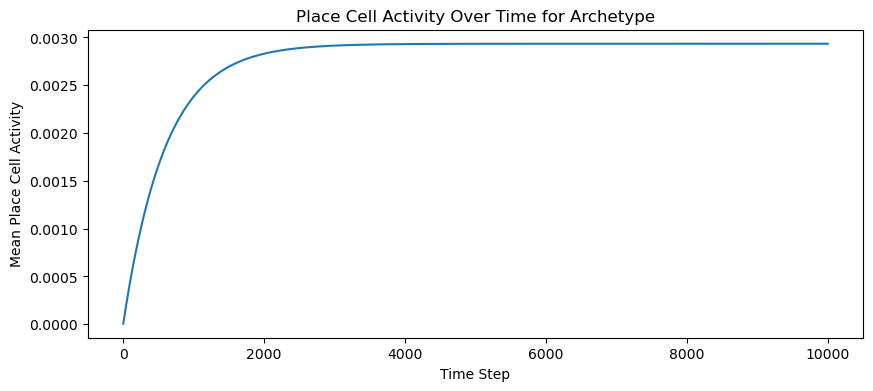

In [466]:
g_idxes = g_indexes_all.tolist()
p_tests = []
T_s = 5   # 保证收敛
dt = 0.0005
for g_id in g_idxes:
    grid_org = pattern_average_activity[g_id].reshape(-1,1)
    s_new = np.vstack([grid_org, grid_org])   # initialize with previous g
    # print(s_new.shape)
    p_hist = np.zeros((Nh,n_steps_test))
    p_test = np.zeros((Nh, )) 
    n_steps_test = int(T_s/dt)
    # p_hist = np.zeros((Nh,n_steps_test))
    for t in range(n_steps_test):
        hippo_drive = gain_pg * W_pg @ s_new + Iext2
        phi_term = relu(hippo_drive - theta).reshape(-1, 1)
        p_new = p_test + dt / tau_h * (-p_test + phi_term.flatten())
        # r_place_test[:, t:t+1] = p_new.reshape(-1, 1)
        p_test = p_new.flatten()
        p_hist[:,t] = p_test
    # print(p_test.shape)
    p_tests.append(p_test)
p_tests = np.stack(p_tests)  # (Npatts, Nh)

# Visualize
plt.figure(figsize=(10,4))
# 只打印最后一个pattern的place cell活动随时间变化
plt.plot(np.mean(p_hist, axis=0))
plt.xlabel('Time Step')
plt.ylabel('Mean Place Cell Activity')  
plt.title('Place Cell Activity Over Time for Archetype')
plt.show()

In [ ]:
def attractor_test2(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max = 2, dt = 0.01, Nrun = 100,noise_stds = [2], sim_measure = 'Cosine'):
    '''验证多个噪声强度下网络的去噪能力'''
    Nn = len(noise_stds)
    n_steps_test = int(T_max / dt)
    p_sim_all = np.zeros((Nrun, Nn, n_steps_test))  # collect p similarity over time_steps
    for n in range(Nn):
        noise_std = noise_stds[n]
        for r in range(Nrun):
            p_noise, p_denoised, sim_array, g_denoised = g_p_denoise_process(grid_org, p_org, Wgp_L, Wgp_R, W_pg, T_max, dt, noise_std, sim_measure)
            p_sim_all[r, n, :] = sim_array
    
    return p_noise, p_denoised, p_sim_all, g_denoised

In [464]:
p_tests

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# 这个保存所有时刻的相似度变化曲线

from contextlib import contextmanager
import joblib
from joblib import Parallel, delayed
from tqdm.auto import tqdm

ls_noise = [2.0]
T_max = 1.5
dt = 0.0005
g_idxed = g_indexes_all

grid_global_min = 0.0
grid_global_max = pattern_average_activity[g_idxed, :].max()
place_global_max = p_tests.max()
time_axis = np.arange(int(T_max / dt)) * dt

place_pattern_cache = {g_id: p_tests[idx] for idx, g_id in enumerate(g_idxed)}
T_s_relax = 5.0
dt_relax = dt
relax_steps = int(T_s_relax / dt_relax)
def compute_place_pattern(g_id):
    grid_org = pattern_average_activity[g_id].reshape(-1, 1)
    s_new = np.vstack([grid_org, grid_org])
    p_state = np.zeros(Nh)
    for _ in range(relax_steps):
        hippo_drive = gain_pg * W_pg @ s_new + Iext2
        phi_term = relu(hippo_drive - theta).reshape(-1, 1)
        p_state = p_state + dt_relax / tau_h * (-p_state + phi_term.flatten())
    return p_state

def get_place_pattern(g_id):
    if g_id not in place_pattern_cache:
        place_pattern_cache[g_id] = compute_place_pattern(g_id)
    return place_pattern_cache[g_id]

@contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)
    old_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_callback
        tqdm_object.close()

def _simulate_pattern(task):
    _, g_id = task
    grid_org = pattern_average_activity[g_id]
    p_org = get_place_pattern(g_id)
    return attractor_test2(
        grid_org,
        p_org,
        Wgp_L_pre,
        Wgp_R_pre,
        W_pg,
        T_max=T_max,
        dt=dt,
        Nrun=100,
        noise_stds=ls_noise,
        sim_measure='Cosine'
    )

n_jobs = min(len(g_idxed), os.cpu_count() or 1)
with tqdm_joblib(tqdm(total=len(g_idxed), desc='Running attractor tests')):
    results = Parallel(n_jobs=n_jobs, prefer='threads')(
        delayed(_simulate_pattern)(task) for task in enumerate(g_idxed)
    )

p_noise_all, p_denoised_all, p_sim_all, g_denoised_all = [
    list(values) for values in zip(*results)
]

Running attractor tests:   0%|          | 0/32 [00:00<?, ?it/s]

In [469]:
# exoprt results
time = datetime.now().strftime("%m%d_%H%M%S")
# export_dir = os.path.join(folder_path, 'exports', f'pg_Mul-1D_denoise_{N}_{time}')
# os.makedirs(export_dir, exist_ok=True)
export_dir = r'D:\\prob_learning\\grid_cell\\202601_Loop model\\visualization\\exports\\pg_Mul-1D_denoise_32_0206'
np.save(
    os.path.join(export_dir, 'p_sim_all.npy'),
    np.array(p_sim_all, dtype=object),
    allow_pickle=True
)
np.save(
    os.path.join(export_dir, 'g_denoised_all.npy'),
    np.array(g_denoised_all, dtype=object),
    allow_pickle=True
)

In [473]:
p_sim_all_arr = np.array(p_sim_all)

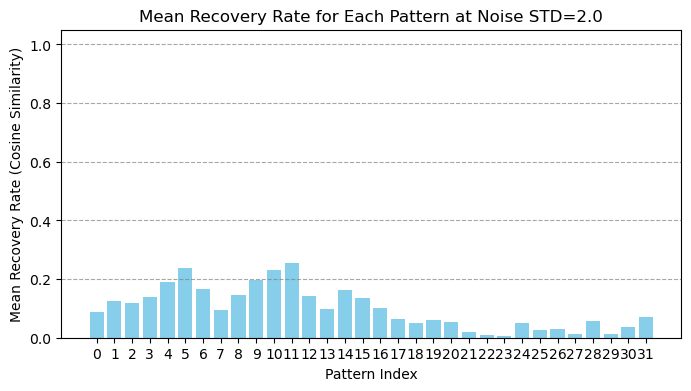

In [474]:
mean_recover_rate = p_sim_all_arr[:, :, 0, -1].mean(axis=1)  # 每个pattern在最大噪声强度下的平均恢复率
plt.figure(figsize=(8,4))
plt.bar(g_idxed, mean_recover_rate, color='skyblue') 
plt.xlabel('Pattern Index')
plt.ylabel('Mean Recovery Rate (Cosine Similarity)')
plt.title('Mean Recovery Rate for Each Pattern at Noise STD={}'.format(ls_noise[0]))
plt.ylim(0, 1.05)
plt.xticks(g_idxed)
plt.grid(axis='y', color='grey', linestyle='--', alpha=0.7
)
plt.show()
